# Optimise on a big dataframe

In [1]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

In [3]:
filename_list = ["quad_scan_east_dump_2022_04_11_13h17m30s","quad_scan_east_dump_2022_04_11_13h47m05s", "quad_scan_east_dump_2022_04_11_14h28m24s", "quad_scan_east_dump_2022_04_11_14h44m15s", "quad_scan_east_dump_2022_04_11_15h03m36s"]

In [5]:
# Create an empty df
master_df_H = pd.DataFrame()
master_df_V = pd.DataFrame()

# First data measurement

Text(0.5, 1.0, 'Beam size')

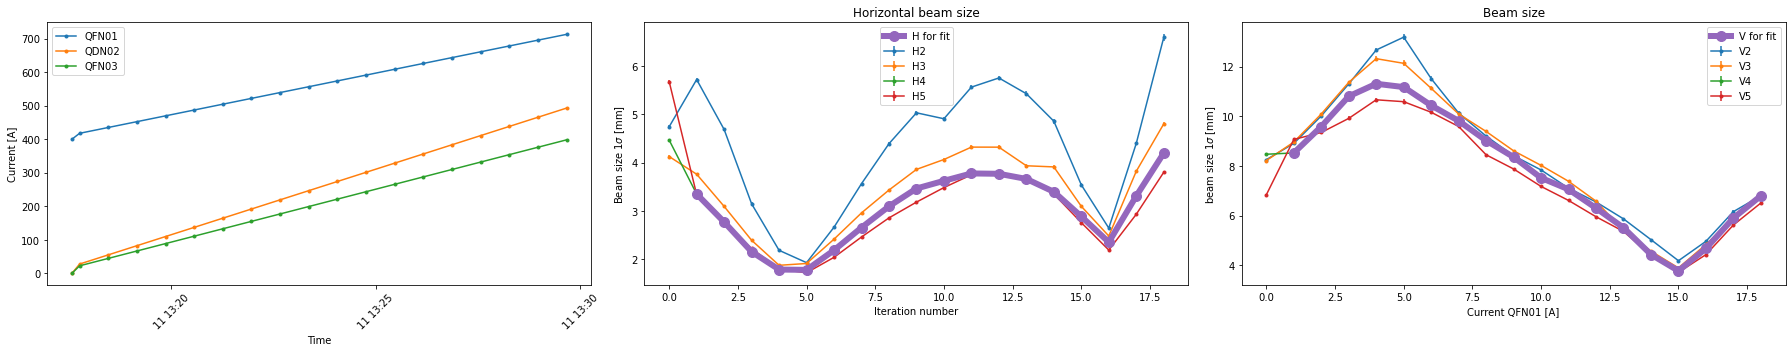

In [6]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[0]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [1,len(acquisition)]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [1,len(acquisition)]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

# Second data measurement

Text(0.5, 1.0, 'Beam size')

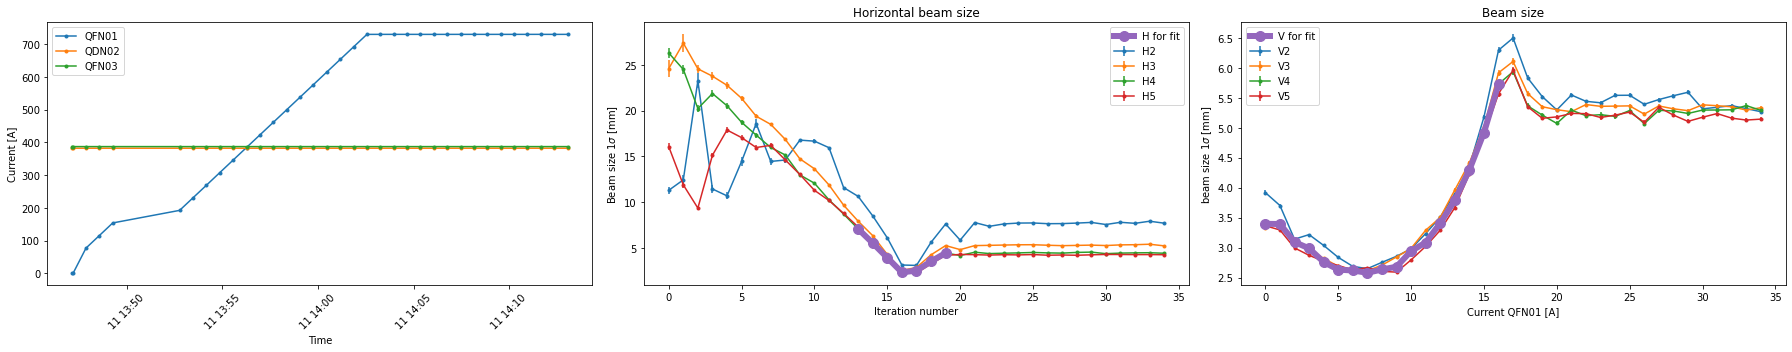

In [7]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[1]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [13,len(acquisition)-15]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [0,len(acquisition)-18]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

# Third measurements

Text(0.5, 1.0, 'Beam size')

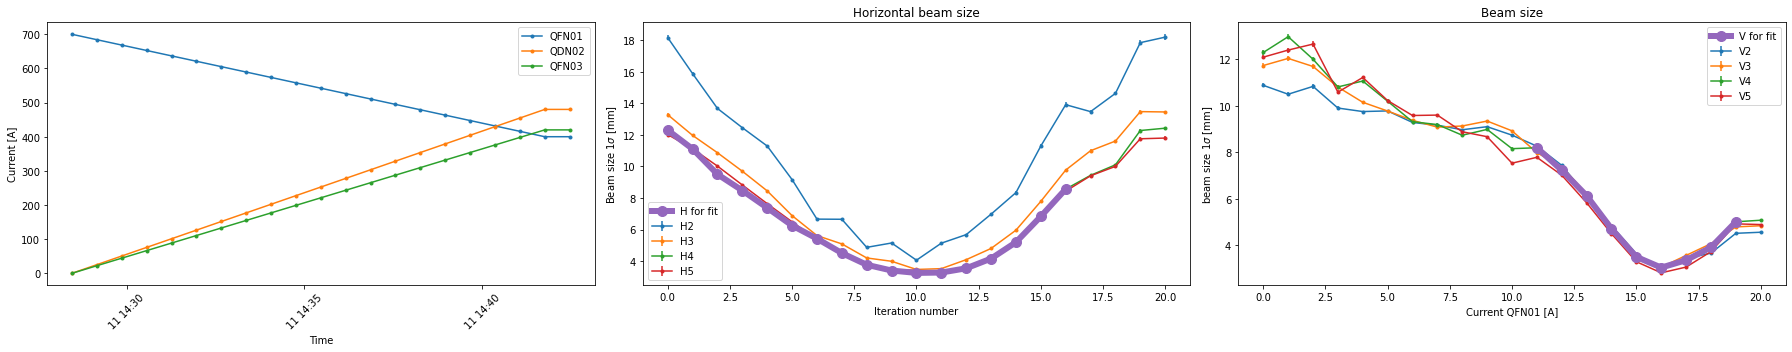

In [8]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[2]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [0,len(acquisition)-4]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [11,len(acquisition)-1]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

# Fourth measurement

Text(0.5, 1.0, 'Beam size')

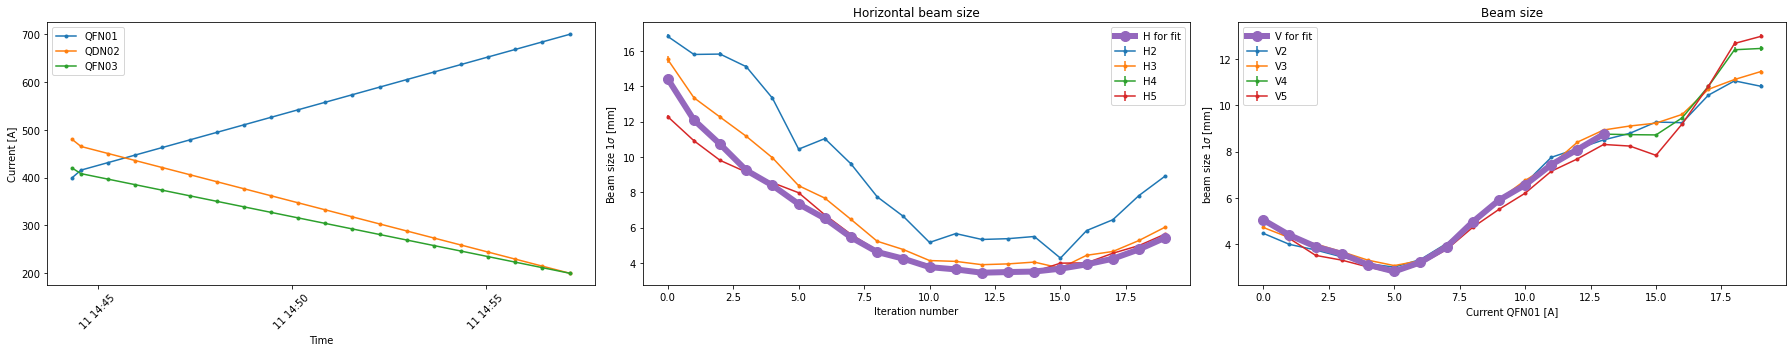

In [9]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[3]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [0,len(acquisition)-0]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [0,len(acquisition)-6]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

# Fifth measurement

Text(0.5, 1.0, 'Beam size')

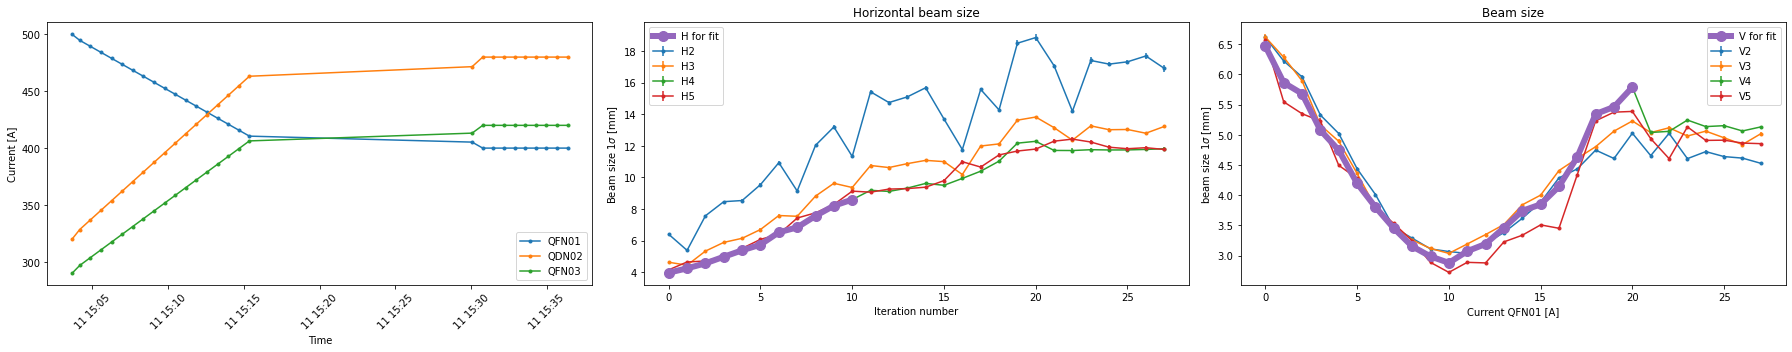

In [10]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[4]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [0,len(acquisition)-17]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [0,len(acquisition)-7]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

# Optimize on a dataframe

In [11]:
header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
gamma = header_read["gamma"]
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread
Brho = 24*3.3356

quad_current = {
    "QFN01": 620,
    "QDN02": 404,
    "QFN03": 378,
}
quad_length = {
    "QFN01": 0.74,
    "QDN02": 1.2,
    "QFN03": 1.2,
}

In [ ]:
# Py-BOBYQA example: minimize the Rosenbrock function
from __future__ import print_function
import pybobyqa

exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

# Define the objective function
def f_fit(params):
    print(params)
    betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn, sige = params

    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)

    madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
    
    # Compare the horizontal beam sizes
    H_sigma_madx = []
    for i in range(len(master_df_H)):
        quad_current["QFN01"] = master_df_H.qfn01_current[i]
        quad_current["QDN02"] = master_df_H.qdn02_current[i]
        quad_current["QFN03"] = master_df_H.qfn03_current[i]

        madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
        madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
        madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

        madx.use(sequence="f61d")
        twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

        H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )

    deltaH = abs(master_df_H.sigma_H - np.array(H_sigma_madx)*1000)**2
    
    # Compare the vertical beam sizes
    V_sigma_madx = []
    for i in range(len(master_df_V)):
        quad_current["QFN01"] = master_df_V.qfn01_current[i]
        quad_current["QDN02"] = master_df_V.qdn02_current[i]
        quad_current["QFN03"] = master_df_V.qfn03_current[i]

        madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
        madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
        madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

        madx.use(sequence="f61d")
        twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

        V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

    deltaV = abs(master_df_V.sigma_V - np.array(V_sigma_madx)*1000)**2
    
    objective = sum(deltaH) + sum(deltaV)
        
    print (objective)
    return (objective)

# Define the starting point
# initial_guess = [82.4, 33.2, -11.1, 0.28, 0.13, 0.0, 0.02, 0.0, 1.5e-6, 1.5e-6, 7.53e-4]
initial_guess = [8.10320374e+01, 1.75850966e+00, -1.24235188e+01, 1.38448554e+00, -4.89293824e+00, -9.90627329e-01, -1.26489793e+00, -3.91133201e-02, 1.49710514e-06, 1.48850811e-06, 7.50894919e-04]

# Define bound constraints (lower <= x <= upper)
lower = np.array([1, 1, -100, -100, -100, -100, -100, -100, 0.0, 0.0, 0.0])
upper = np.array([150, 150, 100, 100, 100, 100, 100, 100, 5.0e-6, 5.0e-6, 20.0e-4])


# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=False, scaling_within_bounds=True, rhoend=1e-8, maxfun=10000)

# Display output
print(soln)

[ 8.10320374e+01  1.75850966e+00 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
361.73289542116635
[ 1.50000000e+02  1.75850966e+00 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
1871.5507238096147
[ 8.10320374e+01  7.62585097e+01 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
1456.5038035762489
[ 8.10320374e+01  1.75850966e+00  8.75764812e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
92401.25082638788
[ 8.10320374e+01  1.75850966e+00 -1.24235188e+01  1.00000000e+02
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
8238427.679946911
[ 8.103

840552.2753518104
[ 7.11336199e+01  1.76888942e+01 -2.58873185e+01  5.18406186e+00
 -6.25028114e+00 -2.21487448e-01 -7.59714968e-01 -2.43835457e-01
  5.79775401e-07  1.76163575e-06  8.46996632e-04]
5558.625236081068
[ 6.77077448e+01  1.46569590e+01 -2.36165270e+01  1.41345834e-01
 -4.51833859e+00  9.65340872e+00 -1.10605089e+00  3.68484712e-02
  5.21373057e-07  1.73925056e-06  8.26081637e-04]
60707.274208274495
[ 6.67818166e+01  1.00183327e+01 -2.66696223e+01  5.02745037e+00
 -1.32736195e+00 -9.67762643e-02 -8.85127263e-01 -4.00572082e-02
  4.63844546e-07  1.75073112e-06  8.19512917e-04]
1524.0525288069052
[ 6.70034966e+01  1.53344597e+01 -2.32020546e+01  3.82469853e+00
 -6.39093080e+00  4.57179223e-02 -1.07023514e+00 -1.34368802e-01
  4.55543816e-07  1.72864529e-06  8.06534676e-04]
3024.8284386367704
[ 6.77186452e+01  1.46656330e+01 -2.31065320e+01 -3.25749983e-01
 -4.99309322e+00  2.28716840e-01 -1.13208600e+00  8.22481273e-02
  4.22021838e-07  1.73623027e-06  8.33316907e-04]
315.192

87.35527443433706
[ 6.71799013e+01  1.57576774e+01 -2.48359793e+01 -1.05017852e-01
 -4.52805492e+00 -3.44879170e-02 -1.12043512e+00 -2.24775396e-01
  4.42973118e-07  1.75255517e-06  8.30812534e-04]
88.2609797333806
[ 6.71607446e+01  1.57373789e+01 -2.48662091e+01 -8.83236817e-02
 -4.50888769e+00 -8.88509922e-03 -1.21475400e+00 -2.56976180e-01
  4.45464615e-07  1.75280085e-06  8.30932401e-04]
131.49124303029197
[ 6.71648488e+01  1.57373694e+01 -2.48758378e+01 -1.66767420e-01
 -4.51409798e+00 -3.75961197e-02 -1.14281956e+00 -2.34730692e-01
  4.45987238e-07  1.75397393e-06  8.30723284e-04]
87.40914413660558
[ 6.71563179e+01  1.57731464e+01 -2.48934215e+01 -7.85028007e-02
 -4.49770757e+00 -2.21932269e-02 -1.12919158e+00 -2.27476074e-01
  4.44730893e-07  1.75293463e-06  8.30644643e-04]
85.31554128429428
[ 6.71586385e+01  1.57723749e+01 -2.48828176e+01 -7.36227081e-02
 -4.49310267e+00 -1.96511670e-02 -1.12684523e+00 -2.22411120e-01
  4.44943615e-07  1.75281868e-06  8.30464303e-04]
85.6328183

84.26439487962
[ 6.71961143e+01  1.57942898e+01 -2.48753691e+01 -4.96456842e-02
 -4.40238717e+00 -5.72919537e-02 -1.11040596e+00 -2.26090241e-01
  4.44587891e-07  1.75271910e-06  8.30689733e-04]
83.88983052685458
[ 6.71996099e+01  1.57936318e+01 -2.48784807e+01 -5.05073228e-02
 -4.39888901e+00 -5.64853854e-02 -1.11004094e+00 -2.25908324e-01
  4.44730899e-07  1.75280316e-06  8.30658593e-04]
83.87598711940053
[ 6.71993936e+01  1.57931858e+01 -2.48783034e+01 -5.02311435e-02
 -4.39828943e+00 -5.68514466e-02 -1.10951625e+00 -2.21821004e-01
  4.44759263e-07  1.75280144e-06  8.30682432e-04]
84.00740967297477
[ 6.71980469e+01  1.57941581e+01 -2.48768458e+01 -5.04877753e-02
 -4.39833995e+00 -5.79948227e-02 -1.10982180e+00 -2.25202227e-01
  4.44752761e-07  1.75287326e-06  8.30682409e-04]
83.88226404929802
[ 6.71988921e+01  1.57944905e+01 -2.48788505e+01 -5.13988626e-02
 -4.39936189e+00 -5.67040829e-02 -1.10944273e+00 -2.25052270e-01
  4.44734937e-07  1.75280369e-06  8.30645660e-04]
83.8702754577

83.71866986396441
[ 6.72123068e+01  1.57893833e+01 -2.48910901e+01 -5.11370594e-02
 -4.37994909e+00 -4.27236772e-02 -1.10302662e+00 -2.27115215e-01
  4.45042136e-07  1.75319227e-06  8.30611336e-04]
83.71605061567513
[ 6.72124029e+01  1.57893425e+01 -2.48906854e+01 -5.11130098e-02
 -4.37926637e+00 -4.23523119e-02 -1.10293322e+00 -2.27090262e-01
  4.45051680e-07  1.75319652e-06  8.30609663e-04]
83.71408092834137
[ 6.72126499e+01  1.57892734e+01 -2.48908262e+01 -5.12654827e-02
 -4.37844998e+00 -4.22770900e-02 -1.10278511e+00 -2.27107470e-01
  4.45060773e-07  1.75319802e-06  8.30610565e-04]
83.71102632508692
[ 6.72139842e+01  1.57889433e+01 -2.48916605e+01 -5.08306695e-02
 -4.37556786e+00 -4.23823567e-02 -1.10204853e+00 -2.27162871e-01
  4.45085428e-07  1.75319655e-06  8.30624246e-04]
83.7012385038071
[ 6.72223319e+01  1.57856454e+01 -2.48955819e+01 -4.66671498e-02
 -4.36965911e+00 -4.29002506e-02 -1.09964624e+00 -2.27209617e-01
  4.45218570e-07  1.75322070e-06  8.30652335e-04]
83.68747365

83.65280179003037
[ 6.72256007e+01  1.57771356e+01 -2.48950580e+01 -4.84638972e-02
 -4.36050801e+00 -4.73462737e-02 -1.09837074e+00 -2.27073459e-01
  4.45267457e-07  1.75325413e-06  8.30797402e-04]
83.65070876676185
[ 6.72262011e+01  1.57765654e+01 -2.48954332e+01 -4.92291417e-02
 -4.36170895e+00 -4.59914187e-02 -1.09866529e+00 -2.27052301e-01
  4.45246730e-07  1.75324363e-06  8.30828722e-04]
83.64852681346132
[ 6.72263679e+01  1.57751969e+01 -2.48955325e+01 -4.89480093e-02
 -4.36263400e+00 -4.71794766e-02 -1.09889928e+00 -2.26947215e-01
  4.45176204e-07  1.75324623e-06  8.30843502e-04]
83.64723494384089
[ 6.72261660e+01  1.57741830e+01 -2.48947912e+01 -5.01792359e-02
 -4.36346889e+00 -4.75490394e-02 -1.09894094e+00 -2.26824312e-01
  4.45201261e-07  1.75323944e-06  8.30875251e-04]
83.64531732735973
[ 6.72266652e+01  1.57730929e+01 -2.48933478e+01 -4.97382090e-02
 -4.36374642e+00 -4.91851057e-02 -1.09907326e+00 -2.26558384e-01
  4.45181638e-07  1.75321465e-06  8.30901117e-04]
83.6454772

83.58798923343105
[ 6.72323737e+01  1.57527168e+01 -2.49003957e+01 -5.40606289e-02
 -4.35404682e+00 -4.38549993e-02 -1.09726967e+00 -2.27056119e-01
  4.44793464e-07  1.75331793e-06  8.31207017e-04]
83.58586111482731
[ 6.72318508e+01  1.57519632e+01 -2.49008412e+01 -5.36519439e-02
 -4.35434368e+00 -4.38508315e-02 -1.09748460e+00 -2.27141121e-01
  4.44775060e-07  1.75331795e-06  8.31218997e-04]
83.58574445559805
[ 6.72320528e+01  1.57519791e+01 -2.49012809e+01 -5.41968962e-02
 -4.35465553e+00 -4.39542349e-02 -1.09710954e+00 -2.27373773e-01
  4.44774457e-07  1.75331701e-06  8.31222615e-04]
83.58218829784121
[ 6.72322104e+01  1.57516580e+01 -2.49011132e+01 -5.48205298e-02
 -4.35478159e+00 -4.43979884e-02 -1.09721175e+00 -2.27216367e-01
  4.44771826e-07  1.75330951e-06  8.31223196e-04]
83.58127881873615
[ 6.72320237e+01  1.57513950e+01 -2.49009045e+01 -5.50441713e-02
 -4.35445920e+00 -4.44126927e-02 -1.09692039e+00 -2.27326492e-01
  4.44786519e-07  1.75331154e-06  8.31227268e-04]
83.5799345

83.32143424709906
[ 6.71997240e+01  1.56462799e+01 -2.48706634e+01 -7.70666418e-02
 -4.34598565e+00 -3.87703803e-02 -1.09545366e+00 -2.25650786e-01
  4.43739753e-07  1.75305093e-06  8.32684179e-04]
83.32209605885346
[ 6.72006169e+01  1.56468198e+01 -2.48724459e+01 -7.78594876e-02
 -4.34513500e+00 -4.16167800e-02 -1.09513403e+00 -2.25457897e-01
  4.43796124e-07  1.75305231e-06  8.32700883e-04]
83.3235109337981
[ 6.72000508e+01  1.56459477e+01 -2.48711492e+01 -7.63728483e-02
 -4.34523969e+00 -4.19913119e-02 -1.09526146e+00 -2.25813438e-01
  4.43790744e-07  1.75302633e-06  8.32702886e-04]
83.31827882739097
[ 6.72002795e+01  1.56447556e+01 -2.48708482e+01 -7.67122570e-02
 -4.34497538e+00 -4.18990031e-02 -1.09527872e+00 -2.25787333e-01
  4.43812744e-07  1.75302125e-06  8.32707828e-04]
83.31667847756822
[ 6.72004628e+01  1.56442454e+01 -2.48710532e+01 -7.59448495e-02
 -4.34432935e+00 -4.27758323e-02 -1.09506407e+00 -2.25907059e-01
  4.43801236e-07  1.75301662e-06  8.32719433e-04]
83.31493311

83.2083233812844
[ 6.71823635e+01  1.56050881e+01 -2.48572478e+01 -7.82366506e-02
 -4.34142841e+00 -3.66724069e-02 -1.09330870e+00 -2.27339056e-01
  4.43763529e-07  1.75255012e-06  8.33038785e-04]
83.20601956874137
[ 6.71857814e+01  1.56028311e+01 -2.48567309e+01 -8.11399307e-02
 -4.34571063e+00 -3.65652799e-02 -1.09411635e+00 -2.27048233e-01
  4.43763834e-07  1.75253790e-06  8.33062769e-04]
83.19856850289281
[ 6.71884329e+01  1.55992151e+01 -2.48573029e+01 -8.45176976e-02
 -4.34562737e+00 -3.63611149e-02 -1.09400077e+00 -2.27340882e-01
  4.43766411e-07  1.75256066e-06  8.33101565e-04]
83.19257615051552
[ 6.71931662e+01  1.55972283e+01 -2.48562872e+01 -8.53999071e-02
 -4.34845505e+00 -3.75786928e-02 -1.09405815e+00 -2.27102844e-01
  4.43775502e-07  1.75250466e-06  8.33103138e-04]
83.19583280314494
[ 6.71874957e+01  1.55990127e+01 -2.48584677e+01 -8.52797038e-02
 -4.34636679e+00 -3.61540562e-02 -1.09160165e+00 -2.26479136e-01
  4.43804989e-07  1.75254753e-06  8.33117878e-04]
83.24736569

83.04585647317403
[ 6.72192041e+01  1.55369585e+01 -2.48549140e+01 -1.17050892e-01
 -4.34575643e+00 -1.90778740e-02 -1.09420538e+00 -2.27401241e-01
  4.43319426e-07  1.75263102e-06  8.33595833e-04]
83.04242132887308
[ 6.72198815e+01  1.55363259e+01 -2.48556344e+01 -1.17033653e-01
 -4.34556807e+00 -2.03856867e-02 -1.09440361e+00 -2.27339420e-01
  4.43318543e-07  1.75262158e-06  8.33595915e-04]
83.03866818493046
[ 6.72231828e+01  1.55343418e+01 -2.48587673e+01 -1.15067907e-01
 -4.34766830e+00 -2.40692270e-02 -1.09495381e+00 -2.27727267e-01
  4.43304242e-07  1.75258338e-06  8.33611717e-04]
83.04097783906597
[ 6.72222396e+01  1.55357203e+01 -2.48540408e+01 -1.17895494e-01
 -4.34573494e+00 -1.99527096e-02 -1.09447230e+00 -2.26966362e-01
  4.43313025e-07  1.75261805e-06  8.33583226e-04]
83.03757566531726
[ 6.72210499e+01  1.55334145e+01 -2.48537406e+01 -1.19296587e-01
 -4.34528247e+00 -1.96664272e-02 -1.09475421e+00 -2.27082564e-01
  4.43296915e-07  1.75260216e-06  8.33575360e-04]
83.0313399

82.25838172616577
[ 6.71993138e+01  1.48344088e+01 -2.46565532e+01 -3.07834094e-01
 -4.34608431e+00  1.30559652e-02 -1.10607546e+00 -2.50399135e-01
  4.34477582e-07  1.75149901e-06  8.35625338e-04]
88.90621318894509
[ 6.72183974e+01  1.48254559e+01 -2.46552892e+01 -3.07243410e-01
 -4.35810007e+00  1.13341264e-02 -1.10058233e+00 -2.27314615e-01
  4.35006794e-07  1.75159414e-06  8.35505778e-04]
82.16451989376914
[ 6.72034943e+01  1.48338856e+01 -2.46557577e+01 -3.08529854e-01
 -4.35663587e+00  2.58632714e-02 -1.09628785e+00 -2.21942026e-01
  4.34594184e-07  1.75150489e-06  8.35633700e-04]
82.08315367186731
[ 6.72031401e+01  1.48314917e+01 -2.46614087e+01 -3.11049004e-01
 -4.36219401e+00  1.55989810e-02 -1.08482281e+00 -2.31164342e-01
  4.34701550e-07  1.75161684e-06  8.35643984e-04]
83.89306850739389
[ 6.72037961e+01  1.48329066e+01 -2.46618854e+01 -3.11381655e-01
 -4.35865604e+00  1.20039125e-02 -1.09955351e+00 -2.24401137e-01
  4.34627622e-07  1.75165392e-06  8.35667188e-04]
82.0744949

81.89460052166652
[ 6.71992090e+01  1.48351171e+01 -2.46734221e+01 -2.97116033e-01
 -4.34491324e+00  3.65258823e-02 -1.09571417e+00 -2.26954262e-01
  4.34588135e-07  1.75151236e-06  8.35727713e-04]
81.89192571647888
[ 6.72012313e+01  1.48345970e+01 -2.46749952e+01 -2.97026139e-01
 -4.34537674e+00  3.77876484e-02 -1.09589762e+00 -2.27034648e-01
  4.34633763e-07  1.75150394e-06  8.35721634e-04]
81.89068595239999
[ 6.72008348e+01  1.48343907e+01 -2.46763740e+01 -2.97643211e-01
 -4.34494370e+00  3.89881285e-02 -1.09595853e+00 -2.27285266e-01
  4.34704834e-07  1.75153176e-06  8.35736941e-04]
81.89085786018437
[ 6.72013277e+01  1.48353412e+01 -2.46749282e+01 -2.96601624e-01
 -4.34518717e+00  3.90350872e-02 -1.09588565e+00 -2.27210178e-01
  4.34631458e-07  1.75149430e-06  8.35725243e-04]
81.8924821909479
[ 6.72015031e+01  1.48337752e+01 -2.46743436e+01 -2.96457062e-01
 -4.34510777e+00  3.75017413e-02 -1.09569321e+00 -2.27131380e-01
  4.34631918e-07  1.75147604e-06  8.35714956e-04]
81.88964306

82.00049355004461
[ 6.72642890e+01  1.47260638e+01 -2.47216769e+01 -2.28941342e-01
 -4.35544410e+00  5.72002561e-03 -1.09977239e+00 -2.30738131e-01
  4.35276683e-07  1.74833819e-06  8.35352317e-04]
81.76788692070048
[ 6.72642009e+01  1.47259397e+01 -2.47199498e+01 -2.31874904e-01
 -4.35882248e+00  6.96070207e-03 -1.10461302e+00 -2.32964604e-01
  4.35325809e-07  1.74823012e-06  8.35405286e-04]
82.09385197137281
[ 6.72651185e+01  1.47253844e+01 -2.47158492e+01 -2.24356548e-01
 -4.35378722e+00  8.59687996e-03 -1.09647984e+00 -2.28147373e-01
  4.35343516e-07  1.74832641e-06  8.35384847e-04]
81.71501855061523
[ 6.72659814e+01  1.47283304e+01 -2.47220187e+01 -2.19644467e-01
 -4.35635033e+00  5.32980599e-03 -1.09771028e+00 -2.28783574e-01
  4.35390209e-07  1.74834608e-06  8.35402354e-04]
81.70583145116984
[ 6.72667883e+01  1.47288382e+01 -2.47210366e+01 -2.18069229e-01
 -4.35452243e+00  6.15061281e-03 -1.10152397e+00 -2.28652306e-01
  4.35373362e-07  1.74836079e-06  8.35390378e-04]
81.7822446

81.66329682665845
[ 6.72772808e+01  1.47069368e+01 -2.47394969e+01 -2.26229786e-01
 -4.34796216e+00  3.85781510e-03 -1.09610546e+00 -2.28520043e-01
  4.35278472e-07  1.74796035e-06  8.35389811e-04]
81.66080818238876
[ 6.72775748e+01  1.47068964e+01 -2.47391261e+01 -2.24727520e-01
 -4.34774963e+00  4.72165539e-03 -1.09605025e+00 -2.28632418e-01
  4.35287264e-07  1.74797763e-06  8.35391778e-04]
81.66044253255932
[ 6.72774839e+01  1.47066590e+01 -2.47387541e+01 -2.24725999e-01
 -4.34707700e+00  4.36498067e-03 -1.09589644e+00 -2.28489758e-01
  4.35282733e-07  1.74798456e-06  8.35392867e-04]
81.66020731081855
[ 6.72776214e+01  1.47070171e+01 -2.47389830e+01 -2.25084914e-01
 -4.34657838e+00  4.50982795e-03 -1.09575087e+00 -2.28514776e-01
  4.35293443e-07  1.74798178e-06  8.35395445e-04]
81.66047940923201
[ 6.72775694e+01  1.47063620e+01 -2.47389120e+01 -2.24673953e-01
 -4.34705694e+00  4.54823773e-03 -1.09513566e+00 -2.28312259e-01
  4.35285269e-07  1.74797710e-06  8.35390485e-04]
81.6648436

81.63008490013257
[ 6.72818961e+01  1.46743212e+01 -2.47733364e+01 -2.07302308e-01
 -4.33810388e+00 -7.03652881e-03 -1.09409074e+00 -2.29156062e-01
  4.35401568e-07  1.74810823e-06  8.35355353e-04]
81.62234080456479
[ 6.72857107e+01  1.46710477e+01 -2.47747792e+01 -1.99177765e-01
 -4.33627180e+00 -1.40895691e-02 -1.09188098e+00 -2.29030409e-01
  4.35195251e-07  1.74810570e-06  8.35315019e-04]
81.64385236160528
[ 6.72814611e+01  1.46746644e+01 -2.47725649e+01 -2.05316208e-01
 -4.33643314e+00 -7.21140594e-03 -1.09293005e+00 -2.30504184e-01
  4.35484456e-07  1.74807063e-06  8.35317678e-04]
81.65673987014932
[ 6.72829352e+01  1.46735168e+01 -2.47772380e+01 -2.03233818e-01
 -4.34150721e+00 -4.39625857e-03 -1.09402812e+00 -2.28982062e-01
  4.35367306e-07  1.74817859e-06  8.35363867e-04]
81.60881445230035
[ 6.72748762e+01  1.46669160e+01 -2.47972996e+01 -1.83518480e-01
 -4.33945617e+00 -3.35331566e-03 -1.09339395e+00 -2.30764827e-01
  4.35334833e-07  1.74830695e-06  8.35357514e-04]
81.6129233

81.52198777763036
[ 6.73280745e+01  1.46131738e+01 -2.48602365e+01 -1.72148341e-01
 -4.33920200e+00 -1.90501451e-02 -1.09350298e+00 -2.29526164e-01
  4.35951253e-07  1.74776179e-06  8.35266878e-04]
81.51856724906929
[ 6.73296756e+01  1.46140732e+01 -2.48635266e+01 -1.69267620e-01
 -4.34012949e+00 -1.77717972e-02 -1.09392203e+00 -2.29602193e-01
  4.35999761e-07  1.74781096e-06  8.35320255e-04]
81.5176864146199
[ 6.73309456e+01  1.46146521e+01 -2.48651957e+01 -1.70068415e-01
 -4.33972426e+00 -1.80348658e-02 -1.09579948e+00 -2.28465383e-01
  4.36000668e-07  1.74781370e-06  8.35311303e-04]
81.55070429174242
[ 6.73296829e+01  1.46130980e+01 -2.48648447e+01 -1.71559674e-01
 -4.34136034e+00 -1.94798988e-02 -1.09429656e+00 -2.29199486e-01
  4.35998639e-07  1.74784633e-06  8.35327721e-04]
81.51640379637317
[ 6.73293697e+01  1.46135308e+01 -2.48645213e+01 -1.71273699e-01
 -4.33838093e+00 -1.97171545e-02 -1.09334262e+00 -2.29422933e-01
  4.35977212e-07  1.74784339e-06  8.35349303e-04]
81.51787676

81.49855430733462
[ 6.73382304e+01  1.46010642e+01 -2.48843165e+01 -1.65458257e-01
 -4.33779695e+00 -2.01461321e-02 -1.09348165e+00 -2.29411745e-01
  4.36220536e-07  1.74757678e-06  8.35408217e-04]
81.49805811021433
[ 6.73379283e+01  1.46003514e+01 -2.48834142e+01 -1.65816244e-01
 -4.33648032e+00 -1.83055477e-02 -1.09283785e+00 -2.29290966e-01
  4.36242609e-07  1.74759839e-06  8.35434486e-04]
81.49918055582764
[ 6.73378126e+01  1.46015245e+01 -2.48846759e+01 -1.65590216e-01
 -4.33742647e+00 -2.00330149e-02 -1.09346668e+00 -2.29677643e-01
  4.36219211e-07  1.74757532e-06  8.35410532e-04]
81.49915696025022
[ 6.73382625e+01  1.46006800e+01 -2.48844769e+01 -1.66639415e-01
 -4.33733448e+00 -1.93898576e-02 -1.09342038e+00 -2.29346437e-01
  4.36219746e-07  1.74757989e-06  8.35395966e-04]
81.4980774907725
[ 6.73381960e+01  1.46008104e+01 -2.48845682e+01 -1.65544288e-01
 -4.33803706e+00 -1.99377635e-02 -1.09298928e+00 -2.29576633e-01
  4.36204184e-07  1.74757424e-06  8.35408690e-04]
81.49771479

81.39158999293925
[ 6.73512578e+01  1.44690411e+01 -2.50148895e+01 -2.99433262e-01
 -4.32223048e+00  2.71845889e-02 -1.08933255e+00 -2.28209561e-01
  4.36314399e-07  1.74514678e-06  8.35961946e-04]
81.35036298800051
[ 6.73499813e+01  1.44689020e+01 -2.50156463e+01 -3.01130527e-01
 -4.32311813e+00  2.55751973e-02 -1.08942609e+00 -2.28271322e-01
  4.36311439e-07  1.74516936e-06  8.35938804e-04]
81.3545394842248
[ 6.73511012e+01  1.44690306e+01 -2.50155001e+01 -2.99029661e-01
 -4.32190008e+00  2.82037530e-02 -1.08984818e+00 -2.28112097e-01
  4.36331213e-07  1.74513030e-06  8.35951412e-04]
81.35510416965298
[ 6.73508895e+01  1.44688806e+01 -2.50134739e+01 -2.99410329e-01
 -4.32224666e+00  2.76819258e-02 -1.08897367e+00 -2.28121323e-01
  4.36335695e-07  1.74516357e-06  8.35965736e-04]
81.3485945252993
[ 6.73502767e+01  1.44698477e+01 -2.50138577e+01 -2.99449537e-01
 -4.32160545e+00  2.80703668e-02 -1.08887056e+00 -2.28323541e-01
  4.36330018e-07  1.74517515e-06  8.35973543e-04]
81.349824531

81.33097347330003
[ 6.73555298e+01  1.44547151e+01 -2.50260794e+01 -3.07375381e-01
 -4.32569905e+00  3.37491450e-02 -1.08996368e+00 -2.28113086e-01
  4.36436414e-07  1.74484835e-06  8.36123592e-04]
81.33082403326225
[ 6.73554904e+01  1.44547587e+01 -2.50267818e+01 -3.07010981e-01
 -4.32532995e+00  3.31578844e-02 -1.08969827e+00 -2.28484336e-01
  4.36443063e-07  1.74484415e-06  8.36121425e-04]
81.32977822182181
[ 6.73558789e+01  1.44544412e+01 -2.50263879e+01 -3.06990720e-01
 -4.32556351e+00  3.32029284e-02 -1.08954029e+00 -2.28310947e-01
  4.36452927e-07  1.74483681e-06  8.36123353e-04]
81.32943184001417
[ 6.73558326e+01  1.44545246e+01 -2.50265050e+01 -3.07501528e-01
 -4.32589092e+00  3.29782214e-02 -1.08971307e+00 -2.28344406e-01
  4.36451480e-07  1.74482659e-06  8.36129269e-04]
81.3293423911037
[ 6.73563195e+01  1.44542632e+01 -2.50263822e+01 -3.07572963e-01
 -4.32550301e+00  3.32394291e-02 -1.08959956e+00 -2.28307234e-01
  4.36441029e-07  1.74482320e-06  8.36129851e-04]
81.32923057

81.31396837364801
[ 6.73658352e+01  1.44396601e+01 -2.50353133e+01 -2.99627894e-01
 -4.33116584e+00  3.20850879e-02 -1.09089492e+00 -2.28790670e-01
  4.36350079e-07  1.74443783e-06  8.36197497e-04]
81.31282328635314
[ 6.73667629e+01  1.44387830e+01 -2.50357162e+01 -2.99338761e-01
 -4.33057648e+00  3.22781358e-02 -1.09058189e+00 -2.28762987e-01
  4.36340444e-07  1.74442709e-06  8.36197857e-04]
81.31233905443862
[ 6.73669175e+01  1.44384054e+01 -2.50367611e+01 -2.98916985e-01
 -4.33177485e+00  3.21908274e-02 -1.09096171e+00 -2.28800149e-01
  4.36338675e-07  1.74441699e-06  8.36206059e-04]
81.312305925705
[ 6.73666660e+01  1.44383448e+01 -2.50367540e+01 -2.98582149e-01
 -4.33178561e+00  3.26285291e-02 -1.09083466e+00 -2.28158908e-01
  4.36340404e-07  1.74440857e-06  8.36204333e-04]
81.31777286780459
[ 6.73673319e+01  1.44385151e+01 -2.50363399e+01 -2.99250164e-01
 -4.33178040e+00  3.18954335e-02 -1.09077868e+00 -2.28825146e-01
  4.36327484e-07  1.74441126e-06  8.36206836e-04]
81.312874860

81.2667366752101
[ 6.73823907e+01  1.43846361e+01 -2.50381587e+01 -2.72889978e-01
 -4.32714276e+00  1.68524005e-02 -1.08921423e+00 -2.29523193e-01
  4.36049437e-07  1.74333235e-06  8.36738811e-04]
81.26364917968158
[ 6.73820396e+01  1.43847434e+01 -2.50377272e+01 -2.73355020e-01
 -4.32697617e+00  1.74530789e-02 -1.08983064e+00 -2.28991739e-01
  4.36051348e-07  1.74333970e-06  8.36748816e-04]
81.25552576932182
[ 6.73817386e+01  1.43848869e+01 -2.50371678e+01 -2.73386354e-01
 -4.32656509e+00  1.70658039e-02 -1.08975036e+00 -2.28855087e-01
  4.36056977e-07  1.74333540e-06  8.36751291e-04]
81.25560980516487
[ 6.73819118e+01  1.43849416e+01 -2.50377273e+01 -2.73388669e-01
 -4.32692937e+00  1.75333609e-02 -1.08988457e+00 -2.29013084e-01
  4.36051944e-07  1.74334562e-06  8.36745989e-04]
81.25557671236625
[ 6.73819942e+01  1.43848203e+01 -2.50379011e+01 -2.73078741e-01
 -4.32683467e+00  1.77125927e-02 -1.08985206e+00 -2.28888334e-01
  4.36049661e-07  1.74333626e-06  8.36749656e-04]
81.25512833

81.24609843121956
[ 6.73803802e+01  1.43736678e+01 -2.50317773e+01 -2.69131926e-01
 -4.32754161e+00  1.85071287e-02 -1.09039983e+00 -2.29389382e-01
  4.35852041e-07  1.74327378e-06  8.36756852e-04]
81.24602455704627
[ 6.73806424e+01  1.43739268e+01 -2.50316481e+01 -2.69302897e-01
 -4.32755926e+00  1.79510500e-02 -1.09024829e+00 -2.29286466e-01
  4.35848474e-07  1.74327530e-06  8.36757430e-04]
81.24570940248063
[ 6.73799062e+01  1.43736272e+01 -2.50302884e+01 -2.70447456e-01
 -4.32610966e+00  1.64165341e-02 -1.08988229e+00 -2.29220229e-01
  4.35857129e-07  1.74326118e-06  8.36747892e-04]
81.24587581146184
[ 6.73807963e+01  1.43743030e+01 -2.50319236e+01 -2.69502182e-01
 -4.32709804e+00  1.76804649e-02 -1.09063012e+00 -2.29615619e-01
  4.35864695e-07  1.74327013e-06  8.36759422e-04]
81.2492904371324
[ 6.73802579e+01  1.43733312e+01 -2.50311702e+01 -2.69156334e-01
 -4.32756432e+00  1.74921135e-02 -1.09015205e+00 -2.29235728e-01
  4.35821691e-07  1.74327940e-06  8.36758290e-04]
81.24509471

81.22691197589988
[ 6.73763852e+01  1.43478959e+01 -2.50203018e+01 -2.48224019e-01
 -4.32784934e+00  1.09085579e-02 -1.09066938e+00 -2.29698268e-01
  4.35531817e-07  1.74309375e-06  8.36709681e-04]
81.22643992987156
[ 6.73768812e+01  1.43471586e+01 -2.50219307e+01 -2.46453995e-01
 -4.32937534e+00  1.06333036e-02 -1.09104301e+00 -2.29711894e-01
  4.35515655e-07  1.74309242e-06  8.36707113e-04]
81.22684220950258
[ 6.73764217e+01  1.43481575e+01 -2.50198228e+01 -2.47988357e-01
 -4.32754271e+00  1.01581326e-02 -1.09127864e+00 -2.29973064e-01
  4.35507187e-07  1.74308779e-06  8.36708338e-04]
81.23225523746157
[ 6.73759292e+01  1.43475565e+01 -2.50194595e+01 -2.47482453e-01
 -4.32792203e+00  1.05609264e-02 -1.09053041e+00 -2.29611253e-01
  4.35524857e-07  1.74311121e-06  8.36709621e-04]
81.22590470343704
[ 6.73751387e+01  1.43445242e+01 -2.50164382e+01 -2.44140920e-01
 -4.32716849e+00  9.95443384e-03 -1.09030295e+00 -2.29668953e-01
  4.35515636e-07  1.74308435e-06  8.36701300e-04]
81.2246314

81.212709416731
[ 6.73695342e+01  1.43278227e+01 -2.49977767e+01 -2.30897899e-01
 -4.32690510e+00 -5.60524033e-04 -1.09009034e+00 -2.29560500e-01
  4.35753273e-07  1.74294805e-06  8.36702538e-04]
81.21247356317386
[ 6.73694952e+01  1.43270852e+01 -2.49979237e+01 -2.30577680e-01
 -4.32726353e+00 -1.86901326e-04 -1.09019379e+00 -2.29617651e-01
  4.35742101e-07  1.74294600e-06  8.36712361e-04]
81.21165754829312
[ 6.73688351e+01  1.43235023e+01 -2.49993441e+01 -2.30251584e-01
 -4.32891202e+00 -5.69407456e-04 -1.09068877e+00 -2.29673914e-01
  4.35694540e-07  1.74294687e-06  8.36740978e-04]
81.20925614327737
[ 6.73693764e+01  1.43201762e+01 -2.49996337e+01 -2.30908999e-01
 -4.32715414e+00 -2.39034396e-03 -1.09005546e+00 -2.29596950e-01
  4.35610872e-07  1.74291226e-06  8.36738649e-04]
81.2083766975683
[ 6.73695733e+01  1.43189819e+01 -2.50010607e+01 -2.35491874e-01
 -4.32641177e+00 -2.22748409e-03 -1.09038818e+00 -2.29406453e-01
  4.35522626e-07  1.74294747e-06  8.36735268e-04]
81.2104722273

81.14220934858878
[ 6.73493891e+01  1.41725113e+01 -2.50084065e+01 -1.89962608e-01
 -4.33068137e+00 -1.58688798e-02 -1.08897910e+00 -2.35680474e-01
  4.33914598e-07  1.74164625e-06  8.37433070e-04]
81.37857111179437
[ 6.73483000e+01  1.41729546e+01 -2.50137701e+01 -1.91054684e-01
 -4.33118219e+00 -1.97891981e-02 -1.09224614e+00 -2.30487873e-01
  4.33907528e-07  1.74161695e-06  8.37424626e-04]
81.12296993175337
[ 6.73494822e+01  1.41724589e+01 -2.50085911e+01 -1.92545706e-01
 -4.33068606e+00 -1.72252952e-02 -1.08962700e+00 -2.29310721e-01
  4.33884861e-07  1.74164936e-06  8.37437868e-04]
81.1415160001757
[ 6.73489400e+01  1.41725871e+01 -2.50102449e+01 -1.90305068e-01
 -4.32907643e+00 -1.49881170e-02 -1.09074790e+00 -2.30539373e-01
  4.33941721e-07  1.74165331e-06  8.37436688e-04]
81.11664989952871
[ 6.73474636e+01  1.41721796e+01 -2.50090480e+01 -1.91101196e-01
 -4.33027864e+00 -1.65474669e-02 -1.09049077e+00 -2.30097741e-01
  4.33902409e-07  1.74166151e-06  8.37434312e-04]
81.11946129

81.26433400126211
[ 6.73356428e+01  1.39326359e+01 -2.50758726e+01 -1.20260629e-01
 -4.32452651e+00 -5.97325521e-02 -1.09052601e+00 -2.30632154e-01
  4.30252422e-07  1.73951769e-06  8.38163425e-04]
81.03866579150113
[ 6.73416352e+01  1.39049683e+01 -2.51085208e+01 -1.03120575e-01
 -4.32565430e+00 -5.68685314e-02 -1.09198697e+00 -2.32111523e-01
  4.30324367e-07  1.73890863e-06  8.38124129e-04]
81.05164433572644
[ 6.73276966e+01  1.39264840e+01 -2.50771020e+01 -1.30178690e-01
 -4.31494838e+00 -6.69327799e-02 -1.07947762e+00 -2.23482997e-01
  4.30633410e-07  1.73944859e-06  8.38208352e-04]
81.75578975365428
[ 6.73357840e+01  1.39243857e+01 -2.50811359e+01 -1.31352291e-01
 -4.31050889e+00 -6.25032587e-02 -1.08724073e+00 -2.30358236e-01
  4.30728607e-07  1.73945000e-06  8.38160469e-04]
81.0803451855916
[ 6.73340998e+01  1.39327614e+01 -2.50763259e+01 -1.19703527e-01
 -4.32406593e+00 -5.67987855e-02 -1.08186935e+00 -2.41814049e-01
  4.30231081e-07  1.73952932e-06  8.38160334e-04]
82.59922992

81.02105356858189
[ 6.73372546e+01  1.39290722e+01 -2.50792882e+01 -1.08088228e-01
 -4.31922609e+00 -5.60566653e-02 -1.08837160e+00 -2.31419681e-01
  4.30443854e-07  1.73942150e-06  8.38165526e-04]
81.02099477313243
[ 6.73367635e+01  1.39284145e+01 -2.50787272e+01 -1.08483280e-01
 -4.31934542e+00 -5.58878685e-02 -1.08835160e+00 -2.31384882e-01
  4.30428488e-07  1.73941365e-06  8.38171480e-04]
81.02074017351717
[ 6.73347632e+01  1.39258782e+01 -2.50773491e+01 -1.10743524e-01
 -4.31952958e+00 -5.44685830e-02 -1.08855144e+00 -2.31439437e-01
  4.30358533e-07  1.73939007e-06  8.38192316e-04]
81.01979026419193
[ 6.73323900e+01  1.39262635e+01 -2.50747947e+01 -1.13753972e-01
 -4.31841339e+00 -5.33992318e-02 -1.08811027e+00 -2.31382773e-01
  4.30322733e-07  1.73940419e-06  8.38223941e-04]
81.01926845321854
[ 6.73321425e+01  1.39236788e+01 -2.50746029e+01 -1.15501211e-01
 -4.31968840e+00 -5.24229850e-02 -1.08858831e+00 -2.31373112e-01
  4.30218811e-07  1.73936161e-06  8.38240476e-04]
81.0182265

81.0138713358223
[ 6.73269458e+01  1.39109650e+01 -2.50723481e+01 -1.12012247e-01
 -4.31992522e+00 -5.52791459e-02 -1.08852800e+00 -2.31306197e-01
  4.29753749e-07  1.73926104e-06  8.38379123e-04]
81.01340917832431
[ 6.73266158e+01  1.39105654e+01 -2.50718347e+01 -1.10374734e-01
 -4.31907049e+00 -5.67841414e-02 -1.08812451e+00 -2.31206231e-01
  4.29713800e-07  1.73925133e-06  8.38388809e-04]
81.01381312667633
[ 6.73268309e+01  1.39107603e+01 -2.50721177e+01 -1.12083903e-01
 -4.32008025e+00 -5.53088836e-02 -1.08834659e+00 -2.31217549e-01
  4.29756051e-07  1.73926021e-06  8.38380035e-04]
81.01404282316764
[ 6.73275134e+01  1.39111483e+01 -2.50734506e+01 -1.11608865e-01
 -4.32012342e+00 -5.52845729e-02 -1.08855999e+00 -2.31366101e-01
  4.29739621e-07  1.73925164e-06  8.38377227e-04]
81.01341829940938
[ 6.73268242e+01  1.39108111e+01 -2.50722708e+01 -1.11962650e-01
 -4.31996267e+00 -5.53554621e-02 -1.08885429e+00 -2.31293075e-01
  4.29753983e-07  1.73926608e-06  8.38378314e-04]
81.01374868

81.01064932415726
[ 6.73254088e+01  1.39015118e+01 -2.50701565e+01 -1.15609732e-01
 -4.31973577e+00 -5.34197364e-02 -1.08859749e+00 -2.31414330e-01
  4.29494404e-07  1.73902314e-06  8.38392208e-04]
81.01053774167625
[ 6.73253280e+01  1.39007553e+01 -2.50701356e+01 -1.15906965e-01
 -4.31965058e+00 -5.36108869e-02 -1.08851357e+00 -2.31393331e-01
  4.29478984e-07  1.73901184e-06  8.38401110e-04]
81.01028989658614
[ 6.73253691e+01  1.38968309e+01 -2.50698941e+01 -1.16992750e-01
 -4.31991843e+00 -5.31010552e-02 -1.08866190e+00 -2.31429075e-01
  4.29427483e-07  1.73894460e-06  8.38397386e-04]
81.00954626716351
[ 6.73222985e+01  1.38874107e+01 -2.50652402e+01 -1.25542149e-01
 -4.32125446e+00 -4.72050539e-02 -1.08898214e+00 -2.31620698e-01
  4.29089697e-07  1.73865091e-06  8.38448847e-04]
81.00791651399365
[ 6.73264309e+01  1.38757486e+01 -2.50704815e+01 -1.15038447e-01
 -4.31649005e+00 -5.79262429e-02 -1.08747928e+00 -2.31242488e-01
  4.29020153e-07  1.73843657e-06  8.38403608e-04]
81.0092437

81.0020824770763
[ 6.73199559e+01  1.38640579e+01 -2.50644374e+01 -1.28615397e-01
 -4.32141416e+00 -4.96722289e-02 -1.08909155e+00 -2.31392795e-01
  4.28524565e-07  1.73808751e-06  8.38445956e-04]
81.00210127065748
[ 6.73197662e+01  1.38645588e+01 -2.50646278e+01 -1.28313923e-01
 -4.32018717e+00 -5.03801137e-02 -1.08884682e+00 -2.31384499e-01
  4.28541221e-07  1.73808808e-06  8.38442810e-04]
81.0021976220099
[ 6.73198295e+01  1.38644553e+01 -2.50648005e+01 -1.28550654e-01
 -4.32029876e+00 -5.01678006e-02 -1.08884234e+00 -2.31380135e-01
  4.28526839e-07  1.73809343e-06  8.38446931e-04]
81.00205369336388
[ 6.73199090e+01  1.38643768e+01 -2.50649983e+01 -1.28547187e-01
 -4.32083611e+00 -5.04800818e-02 -1.08900532e+00 -2.31378918e-01
  4.28528724e-07  1.73808799e-06  8.38450284e-04]
81.00217956503162
[ 6.73196981e+01  1.38644520e+01 -2.50647916e+01 -1.28448544e-01
 -4.32029413e+00 -4.99734920e-02 -1.08877360e+00 -2.31401988e-01
  4.28529968e-07  1.73809173e-06  8.38449278e-04]
81.001988607

80.9999411520027
[ 6.73170019e+01  1.38532726e+01 -2.50696790e+01 -1.32307380e-01
 -4.31957831e+00 -4.79339492e-02 -1.08862004e+00 -2.31548939e-01
  4.28393625e-07  1.73788118e-06  8.38500802e-04]
80.99988788710303
[ 6.73164509e+01  1.38530982e+01 -2.50699132e+01 -1.32424945e-01
 -4.31952683e+00 -4.78807454e-02 -1.08861772e+00 -2.31522635e-01
  4.28365213e-07  1.73787427e-06  8.38507981e-04]
80.99969010563684
[ 6.73161974e+01  1.38528669e+01 -2.50701135e+01 -1.32435258e-01
 -4.31954916e+00 -4.70203491e-02 -1.08854903e+00 -2.31585949e-01
  4.28334278e-07  1.73787475e-06  8.38506353e-04]
80.99973129779762
[ 6.73164319e+01  1.38529133e+01 -2.50702437e+01 -1.33062820e-01
 -4.31958235e+00 -4.78370633e-02 -1.08863328e+00 -2.31386530e-01
  4.28364956e-07  1.73787683e-06  8.38509634e-04]
80.99980869589317
[ 6.73161700e+01  1.38529580e+01 -2.50703245e+01 -1.32564710e-01
 -4.31956460e+00 -4.77615444e-02 -1.08862145e+00 -2.31539394e-01
  4.28356736e-07  1.73787740e-06  8.38511546e-04]
80.99959281

80.99448290945293
[ 6.73002829e+01  1.38449239e+01 -2.50787625e+01 -1.40572799e-01
 -4.31852584e+00 -4.47376303e-02 -1.08839775e+00 -2.31414653e-01
  4.27739510e-07  1.73771485e-06  8.38710822e-04]
80.99454829099636
[ 6.73002220e+01  1.38448647e+01 -2.50787795e+01 -1.40562516e-01
 -4.31853855e+00 -4.47263042e-02 -1.08838201e+00 -2.31499370e-01
  4.27739232e-07  1.73771608e-06  8.38711283e-04]
80.99447740819662
[ 6.73001876e+01  1.38448435e+01 -2.50788278e+01 -1.40576437e-01
 -4.31855726e+00 -4.47356704e-02 -1.08838667e+00 -2.31496485e-01
  4.27739619e-07  1.73771753e-06  8.38711505e-04]
80.99447483715585
[ 6.73001406e+01  1.38448501e+01 -2.50788036e+01 -1.40566618e-01
 -4.31852942e+00 -4.47249332e-02 -1.08838248e+00 -2.31499561e-01
  4.27739333e-07  1.73771889e-06  8.38711856e-04]
80.99447068670767
[ 6.73000754e+01  1.38448125e+01 -2.50788339e+01 -1.40544485e-01
 -4.31848235e+00 -4.46598125e-02 -1.08837093e+00 -2.31498622e-01
  4.27736497e-07  1.73772481e-06  8.38714554e-04]
80.9944380

80.98895038550981
[ 6.72840764e+01  1.38428508e+01 -2.50777147e+01 -1.38239332e-01
 -4.32412058e+00 -4.63869514e-02 -1.09006141e+00 -2.31414096e-01
  4.26738059e-07  1.73798768e-06  8.39101855e-04]
80.99207381615223
[ 6.72841108e+01  1.38483083e+01 -2.50804123e+01 -1.37546696e-01
 -4.31946355e+00 -4.53288684e-02 -1.08730508e+00 -2.27545196e-01
  4.26932818e-07  1.73798849e-06  8.39105089e-04]
81.14430560804439
[ 6.72844442e+01  1.38484919e+01 -2.50776474e+01 -1.36318921e-01
 -4.31971033e+00 -4.59559496e-02 -1.08887730e+00 -2.31481835e-01
  4.26904193e-07  1.73802649e-06  8.39129343e-04]
80.98903366466016
[ 6.72854127e+01  1.38487431e+01 -2.50818991e+01 -1.37729908e-01
 -4.31888232e+00 -4.34865889e-02 -1.08854071e+00 -2.32175287e-01
  4.26904482e-07  1.73794782e-06  8.39096594e-04]
80.99220444486136
[ 6.72839888e+01  1.38473357e+01 -2.50831441e+01 -1.35706107e-01
 -4.31815160e+00 -4.58121048e-02 -1.08834585e+00 -2.31602900e-01
  4.26923110e-07  1.73793789e-06  8.39106934e-04]
80.9885415

80.98554657213813
[ 6.72783097e+01  1.38435788e+01 -2.50831364e+01 -1.39119708e-01
 -4.31702831e+00 -4.49722603e-02 -1.08802866e+00 -2.31275477e-01
  4.26552551e-07  1.73784271e-06  8.39265717e-04]
80.98535533881542
[ 6.72766168e+01  1.38427533e+01 -2.50829401e+01 -1.40855974e-01
 -4.31745169e+00 -4.47273447e-02 -1.08817484e+00 -2.31297467e-01
  4.26551318e-07  1.73784151e-06  8.39272991e-04]
80.98518785346349
[ 6.72772265e+01  1.38424208e+01 -2.50816505e+01 -1.41035280e-01
 -4.31745309e+00 -4.45911000e-02 -1.08824173e+00 -2.31289536e-01
  4.26506713e-07  1.73788380e-06  8.39285673e-04]
80.98500769467091
[ 6.72763963e+01  1.38413920e+01 -2.50810656e+01 -1.41062589e-01
 -4.31813615e+00 -4.46659887e-02 -1.08838743e+00 -2.31259544e-01
  4.26450514e-07  1.73790143e-06  8.39294059e-04]
80.98490116523489
[ 6.72751540e+01  1.38336939e+01 -2.50852767e+01 -1.38648405e-01
 -4.31711316e+00 -4.57766874e-02 -1.08804837e+00 -2.31311242e-01
  4.26391321e-07  1.73794526e-06  8.39338387e-04]
80.9838267

80.97997005986252
[ 6.72648879e+01  1.38041272e+01 -2.50895516e+01 -1.37553157e-01
 -4.31405766e+00 -4.74273200e-02 -1.08727434e+00 -2.31263097e-01
  4.25679697e-07  1.73814583e-06  8.39665966e-04]
80.97816963756007
[ 6.72642369e+01  1.38030463e+01 -2.50892570e+01 -1.37453862e-01
 -4.31397541e+00 -4.67369951e-02 -1.08728335e+00 -2.31415326e-01
  4.25681825e-07  1.73814492e-06  8.39656964e-04]
80.97813316194006
[ 6.72641480e+01  1.38033994e+01 -2.50894592e+01 -1.37806082e-01
 -4.31447484e+00 -4.70123242e-02 -1.08746260e+00 -2.31316805e-01
  4.25672665e-07  1.73814659e-06  8.39657075e-04]
80.97808097319441
[ 6.72642969e+01  1.38032439e+01 -2.50900325e+01 -1.37875490e-01
 -4.31405409e+00 -4.68036558e-02 -1.08734095e+00 -2.31311883e-01
  4.25680019e-07  1.73814624e-06  8.39661205e-04]
80.9780252065514
[ 6.72642826e+01  1.38030407e+01 -2.50898893e+01 -1.37342057e-01
 -4.31394835e+00 -4.74074850e-02 -1.08727768e+00 -2.31278451e-01
  4.25683970e-07  1.73814420e-06  8.39664631e-04]
80.97811560

80.9690274439586
[ 6.72687773e+01  1.37963459e+01 -2.50918903e+01 -1.33693375e-01
 -4.30956901e+00 -4.67226858e-02 -1.08631265e+00 -2.31219642e-01
  4.24692165e-07  1.73874908e-06  8.40495685e-04]
80.96893400166763
[ 6.72683014e+01  1.37951707e+01 -2.50920789e+01 -1.35849135e-01
 -4.30938636e+00 -4.68543638e-02 -1.08635989e+00 -2.31105754e-01
  4.24665325e-07  1.73879379e-06  8.40511684e-04]
80.96850274324558
[ 6.72689603e+01  1.37942277e+01 -2.50918211e+01 -1.35466105e-01
 -4.30954654e+00 -4.65831155e-02 -1.08638351e+00 -2.31153201e-01
  4.24655298e-07  1.73883303e-06  8.40542067e-04]
80.96832518476356
[ 6.72677061e+01  1.37943099e+01 -2.50937844e+01 -1.35522485e-01
 -4.30891253e+00 -4.69321327e-02 -1.08625770e+00 -2.31119599e-01
  4.24623255e-07  1.73882782e-06  8.40565782e-04]
80.96791951277656
[ 6.72674347e+01  1.37935104e+01 -2.50958083e+01 -1.35586018e-01
 -4.30797023e+00 -4.64214422e-02 -1.08599073e+00 -2.31129521e-01
  4.24442790e-07  1.73876653e-06  8.40695460e-04]
80.96640334

80.92239295109343
[ 6.72434393e+01  1.37703760e+01 -2.51318523e+01 -1.24480365e-01
 -4.28858545e+00 -4.89518880e-02 -1.08146004e+00 -2.30406185e-01
  4.19838719e-07  1.74038866e-06  8.44444220e-04]
80.92240287631941
[ 6.72446593e+01  1.37746303e+01 -2.51284401e+01 -1.25033852e-01
 -4.28802798e+00 -5.02039240e-02 -1.08159108e+00 -2.29830793e-01
  4.19883204e-07  1.74037046e-06  8.44454267e-04]
80.92424070202978
[ 6.72442044e+01  1.37737612e+01 -2.51296915e+01 -1.24728177e-01
 -4.28921953e+00 -5.07358694e-02 -1.08149429e+00 -2.30166650e-01
  4.19879861e-07  1.74031606e-06  8.44455349e-04]
80.9209852128119
[ 6.72439619e+01  1.37719277e+01 -2.51301149e+01 -1.25245352e-01
 -4.28996487e+00 -5.07855961e-02 -1.08157735e+00 -2.30100930e-01
  4.19821829e-07  1.74029628e-06  8.44446360e-04]
80.92068648996391
[ 6.72451502e+01  1.37697355e+01 -2.51298148e+01 -1.24091320e-01
 -4.28945356e+00 -5.13125891e-02 -1.08152475e+00 -2.30147897e-01
  4.19822089e-07  1.74031587e-06  8.44441692e-04]
80.92088391

80.91735401404377
[ 6.72227479e+01  1.37615548e+01 -2.51395434e+01 -1.30277670e-01
 -4.29055768e+00 -4.91183184e-02 -1.08176878e+00 -2.29962817e-01
  4.19332569e-07  1.74086617e-06  8.44631143e-04]
80.91660566279367
[ 6.72193919e+01  1.37600396e+01 -2.51430884e+01 -1.32013135e-01
 -4.29007217e+00 -4.92731626e-02 -1.08172965e+00 -2.29855971e-01
  4.19266011e-07  1.74085322e-06  8.44660069e-04]
80.91607280130182
[ 6.72152415e+01  1.37591266e+01 -2.51442146e+01 -1.32031752e-01
 -4.29151246e+00 -4.99618277e-02 -1.08199657e+00 -2.29744431e-01
  4.19164539e-07  1.74089274e-06  8.44652391e-04]
80.91617131720436
[ 6.72191736e+01  1.37594513e+01 -2.51437782e+01 -1.33323533e-01
 -4.29306210e+00 -4.92906053e-02 -1.08194539e+00 -2.30149777e-01
  4.19300583e-07  1.74085976e-06  8.44662184e-04]
80.91923372083153
[ 6.72190063e+01  1.37581187e+01 -2.51435344e+01 -1.32793578e-01
 -4.29200579e+00 -4.86123432e-02 -1.08218500e+00 -2.29894201e-01
  4.19234830e-07  1.74084254e-06  8.44664004e-04]
80.9165257

80.91175707457906
[ 6.72002828e+01  1.37392905e+01 -2.51536492e+01 -1.44762439e-01
 -4.28289108e+00 -4.26445495e-02 -1.07983344e+00 -2.29957951e-01
  4.18595522e-07  1.74165759e-06  8.45125214e-04]
80.91153983838598
[ 6.72001157e+01  1.37381192e+01 -2.51542513e+01 -1.45503620e-01
 -4.28256606e+00 -4.30079103e-02 -1.07973126e+00 -2.29804455e-01
  4.18486353e-07  1.74170308e-06  8.45126650e-04]
80.91136802514183
[ 6.72012340e+01  1.37384240e+01 -2.51542933e+01 -1.46982678e-01
 -4.28109027e+00 -4.12177237e-02 -1.07942258e+00 -2.29943684e-01
  4.18550034e-07  1.74174623e-06  8.45152204e-04]
80.9128664487169
[ 6.72008740e+01  1.37382830e+01 -2.51531949e+01 -1.45073621e-01
 -4.28249486e+00 -4.39488174e-02 -1.07939247e+00 -2.29223212e-01
  4.18473512e-07  1.74168201e-06  8.45140156e-04]
80.9158430324031
[ 6.71994272e+01  1.37371098e+01 -2.51527583e+01 -1.45769472e-01
 -4.28233542e+00 -4.21599261e-02 -1.07977905e+00 -2.29875619e-01
  4.18495775e-07  1.74169592e-06  8.45119351e-04]
80.912013082

80.90188192270611
[ 6.71796454e+01  1.37040612e+01 -2.51627228e+01 -1.63061119e-01
 -4.28332141e+00 -3.65966072e-02 -1.08009563e+00 -2.29734583e-01
  4.16994622e-07  1.74324697e-06  8.45613504e-04]
80.90182218222466
[ 6.71797712e+01  1.37040929e+01 -2.51627255e+01 -1.63014783e-01
 -4.28339856e+00 -3.65111884e-02 -1.08019637e+00 -2.29670833e-01
  4.16991786e-07  1.74324699e-06  8.45611196e-04]
80.9019703243683
[ 6.71797617e+01  1.37039452e+01 -2.51626655e+01 -1.63104668e-01
 -4.28344021e+00 -3.65518487e-02 -1.08009868e+00 -2.29750629e-01
  4.16992806e-07  1.74325032e-06  8.45611604e-04]
80.90180688563645
[ 6.71797534e+01  1.37039688e+01 -2.51627113e+01 -1.63128225e-01
 -4.28354121e+00 -3.65746181e-02 -1.08012739e+00 -2.29751836e-01
  4.16991549e-07  1.74325183e-06  8.45612239e-04]
80.9017747867729
[ 6.71797112e+01  1.37040111e+01 -2.51628968e+01 -1.63229413e-01
 -4.28392174e+00 -3.66035149e-02 -1.08021081e+00 -2.29729978e-01
  4.16985309e-07  1.74325711e-06  8.45615349e-04]
80.901656698

80.8921757700157
[ 6.71885402e+01  1.37194430e+01 -2.51623656e+01 -1.44314661e-01
 -4.28377057e+00 -4.16692667e-02 -1.08025093e+00 -2.29860330e-01
  4.15605036e-07  1.74363642e-06  8.46038672e-04]
80.89225802778054
[ 6.71886892e+01  1.37188914e+01 -2.51636212e+01 -1.45241997e-01
 -4.28346137e+00 -4.22869965e-02 -1.07991996e+00 -2.30908588e-01
  4.15640295e-07  1.74363000e-06  8.46029302e-04]
80.90506931640473
[ 6.71887055e+01  1.37192419e+01 -2.51638182e+01 -1.44929158e-01
 -4.28349221e+00 -4.26207112e-02 -1.08019610e+00 -2.29737585e-01
  4.15652129e-07  1.74364100e-06  8.46031345e-04]
80.8918007413377
[ 6.71891702e+01  1.37210710e+01 -2.51657712e+01 -1.42909911e-01
 -4.28297606e+00 -4.31064283e-02 -1.08006902e+00 -2.29770555e-01
  4.15593238e-07  1.74369576e-06  8.46040999e-04]
80.89141697088957
[ 6.71895650e+01  1.37224520e+01 -2.51659705e+01 -1.41197560e-01
 -4.28305166e+00 -4.51955863e-02 -1.08005342e+00 -2.29580215e-01
  4.15504552e-07  1.74373097e-06  8.46034356e-04]
80.890694835

80.8814453747465
[ 6.71988316e+01  1.37503851e+01 -2.51885718e+01 -1.13128970e-01
 -4.28228360e+00 -5.71247001e-02 -1.07989104e+00 -2.29396591e-01
  4.13812543e-07  1.74416440e-06  8.46285372e-04]
80.88077376511967
[ 6.71953064e+01  1.37501055e+01 -2.51921346e+01 -1.12230008e-01
 -4.28441100e+00 -5.72420821e-02 -1.08044534e+00 -2.29437184e-01
  4.13642977e-07  1.74424041e-06  8.46314173e-04]
80.87985641132275
[ 6.71982151e+01  1.37533429e+01 -2.51915598e+01 -1.10237333e-01
 -4.28358635e+00 -5.81671859e-02 -1.08021332e+00 -2.29423035e-01
  4.13477449e-07  1.74424890e-06  8.46359395e-04]
80.87892204616594
[ 6.71977655e+01  1.37637130e+01 -2.52044439e+01 -9.85233755e-02
 -4.28432054e+00 -6.34966359e-02 -1.08037062e+00 -2.29323733e-01
  4.12709240e-07  1.74448216e-06  8.46465773e-04]
80.87591166920237
[ 6.72263952e+01  1.38082505e+01 -2.51946956e+01 -5.00439749e-02
 -4.28831355e+00 -8.43352716e-02 -1.08101268e+00 -2.28943493e-01
  4.09776344e-07  1.74613422e-06  8.46721827e-04]
80.88003287

80.86741381500727
[ 6.72110541e+01  1.37887997e+01 -2.52164383e+01 -7.83138034e-02
 -4.28024958e+00 -7.02276358e-02 -1.07955047e+00 -2.29159681e-01
  4.11136624e-07  1.74479868e-06  8.46854301e-04]
80.86767320362
[ 6.72115883e+01  1.37878479e+01 -2.52175426e+01 -7.83534124e-02
 -4.28015769e+00 -6.93387599e-02 -1.08034945e+00 -2.30209470e-01
  4.11130930e-07  1.74483649e-06  8.46853994e-04]
80.88083627238606
[ 6.72113884e+01  1.37876749e+01 -2.52177225e+01 -7.81511979e-02
 -4.28026959e+00 -6.93808041e-02 -1.07960521e+00 -2.29208802e-01
  4.11116157e-07  1.74485662e-06  8.46859168e-04]
80.86728353457639
[ 6.72118902e+01  1.37869354e+01 -2.52169229e+01 -7.72155306e-02
 -4.27984051e+00 -6.86282220e-02 -1.07957833e+00 -2.29294910e-01
  4.11032929e-07  1.74492921e-06  8.46876141e-04]
80.86721141198609
[ 6.72117429e+01  1.37861963e+01 -2.52168351e+01 -7.71143988e-02
 -4.28048647e+00 -6.87516708e-02 -1.07965507e+00 -2.29247371e-01
  4.11020220e-07  1.74494745e-06  8.46865427e-04]
80.8671487612

80.859516592143
[ 6.71962652e+01  1.37861732e+01 -2.52216090e+01 -7.15248448e-02
 -4.27966766e+00 -7.17074407e-02 -1.07955864e+00 -2.29132983e-01
  4.09937319e-07  1.74546995e-06  8.47280090e-04]
80.85956089600526
[ 6.71958491e+01  1.37863987e+01 -2.52214528e+01 -7.34964498e-02
 -4.27885560e+00 -7.12053606e-02 -1.07925307e+00 -2.29235534e-01
  4.09934860e-07  1.74545890e-06  8.47294570e-04]
80.8596106236324
[ 6.71964880e+01  1.37864833e+01 -2.52210958e+01 -7.31410109e-02
 -4.27928394e+00 -7.12912885e-02 -1.07942196e+00 -2.29112735e-01
  4.09937792e-07  1.74546022e-06  8.47282314e-04]
80.85949856689226
[ 6.71968953e+01  1.37858078e+01 -2.52211898e+01 -7.32230908e-02
 -4.27916983e+00 -7.17777428e-02 -1.07940489e+00 -2.29097430e-01
  4.09943013e-07  1.74546988e-06  8.47284595e-04]
80.85956487844975
[ 6.71965323e+01  1.37865165e+01 -2.52207439e+01 -7.30909938e-02
 -4.27916263e+00 -7.14159312e-02 -1.07950883e+00 -2.29057425e-01
  4.09941085e-07  1.74546389e-06  8.47277884e-04]
80.8596415147

80.85230503761066
[ 6.71932617e+01  1.37625292e+01 -2.52381928e+01 -7.24661990e-02
 -4.28239818e+00 -7.78783970e-02 -1.07963845e+00 -2.27981725e-01
  4.08318606e-07  1.74642230e-06  8.47451589e-04]
80.86163186464925
[ 6.71785385e+01  1.37707182e+01 -2.52277586e+01 -7.98904293e-02
 -4.27595086e+00 -6.78925767e-02 -1.08087092e+00 -2.26715694e-01
  4.08886623e-07  1.74594003e-06  8.47494098e-04]
80.94350030029365
[ 6.71785673e+01  1.37623028e+01 -2.52270215e+01 -7.45663021e-02
 -4.27728185e+00 -7.29333145e-02 -1.07910312e+00 -2.28933551e-01
  4.08638005e-07  1.74610550e-06  8.47606930e-04]
80.85097169413277
[ 6.71715175e+01  1.37589064e+01 -2.52267251e+01 -8.17293935e-02
 -4.27591541e+00 -6.95794288e-02 -1.07881608e+00 -2.29034086e-01
  4.08385741e-07  1.74625625e-06  8.47709194e-04]
80.84888532789678
[ 6.71688270e+01  1.37522607e+01 -2.52265078e+01 -7.95711995e-02
 -4.27596742e+00 -7.40460107e-02 -1.07890229e+00 -2.28702817e-01
  4.08038708e-07  1.74630430e-06  8.47811133e-04]
80.8507708

80.84487703340068
[ 6.71683766e+01  1.37482544e+01 -2.52363319e+01 -8.89686619e-02
 -4.27700061e+00 -6.53191509e-02 -1.07891660e+00 -2.29024238e-01
  4.07996640e-07  1.74649514e-06  8.47794483e-04]
80.84479453168974
[ 6.71683097e+01  1.37480621e+01 -2.52367465e+01 -8.94084656e-02
 -4.27762547e+00 -6.54902924e-02 -1.07906696e+00 -2.28953741e-01
  4.07980992e-07  1.74648859e-06  8.47799813e-04]
80.84472351272458
[ 6.71683225e+01  1.37475716e+01 -2.52359690e+01 -8.94461507e-02
 -4.27752948e+00 -6.55731734e-02 -1.07911397e+00 -2.28960634e-01
  4.07974027e-07  1.74650072e-06  8.47804920e-04]
80.84466202915613
[ 6.71683313e+01  1.37473411e+01 -2.52360142e+01 -8.96574470e-02
 -4.27757770e+00 -6.62900886e-02 -1.07905407e+00 -2.28874607e-01
  4.07954413e-07  1.74651329e-06  8.47801867e-04]
80.84482866010333
[ 6.71683019e+01  1.37475690e+01 -2.52362745e+01 -8.96984699e-02
 -4.27753014e+00 -6.54890656e-02 -1.07917555e+00 -2.29301433e-01
  4.07968555e-07  1.74650204e-06  8.47807610e-04]
80.8457254

80.83216631274372
[ 6.71386095e+01  1.36675414e+01 -2.53069044e+01 -1.15013855e-01
 -4.26853677e+00 -5.73102054e-02 -1.07675797e+00 -2.28515998e-01
  4.04429385e-07  1.74502398e-06  8.48559627e-04]
80.83132016253107
[ 6.71426510e+01  1.36607853e+01 -2.53128072e+01 -1.12899263e-01
 -4.26712471e+00 -5.84734767e-02 -1.07648376e+00 -2.28525751e-01
  4.04292698e-07  1.74500129e-06  8.48622054e-04]
80.83164261881817
[ 6.71377531e+01  1.36690466e+01 -2.53111644e+01 -1.18494986e-01
 -4.26649868e+00 -5.23157555e-02 -1.08752494e+00 -2.25951458e-01
  4.04478279e-07  1.74507637e-06  8.48613109e-04]
81.73284071367813
[ 6.71397485e+01  1.36632190e+01 -2.52989857e+01 -1.11179079e-01
 -4.26778563e+00 -6.25102363e-02 -1.07633626e+00 -2.28128385e-01
  4.04307056e-07  1.74486180e-06  8.48518740e-04]
80.83639711076245
[ 6.71382356e+01  1.36668673e+01 -2.53071460e+01 -1.15330851e-01
 -4.26853332e+00 -5.81788756e-02 -1.07906271e+00 -2.35386030e-01
  4.04430594e-07  1.74504372e-06  8.48550118e-04]
81.2861731

80.82641877599923
[ 6.71341098e+01  1.36639371e+01 -2.53074320e+01 -1.12239190e-01
 -4.27218331e+00 -5.71754230e-02 -1.07790173e+00 -2.29200714e-01
  4.04259859e-07  1.74526637e-06  8.48614697e-04]
80.82647240633247
[ 6.71340333e+01  1.36639911e+01 -2.53074087e+01 -1.12065407e-01
 -4.27201478e+00 -5.72276902e-02 -1.07770612e+00 -2.29158392e-01
  4.04261148e-07  1.74526706e-06  8.48615921e-04]
80.8263831883895
[ 6.71340751e+01  1.36641064e+01 -2.53075306e+01 -1.12302140e-01
 -4.27220917e+00 -5.70974727e-02 -1.07767112e+00 -2.29217295e-01
  4.04267805e-07  1.74526231e-06  8.48616370e-04]
80.82659388899118
[ 6.71341730e+01  1.36642448e+01 -2.53073749e+01 -1.12248093e-01
 -4.27218664e+00 -5.71898325e-02 -1.07780872e+00 -2.29123552e-01
  4.04260840e-07  1.74526438e-06  8.48617276e-04]
80.82631474662955
[ 6.71343009e+01  1.36645759e+01 -2.53070622e+01 -1.12078453e-01
 -4.27215735e+00 -5.72728747e-02 -1.07777750e+00 -2.29104014e-01
  4.04247264e-07  1.74527168e-06  8.48620917e-04]
80.82616736

80.82144955278417
[ 6.71236544e+01  1.36748624e+01 -2.52922781e+01 -1.11491299e-01
 -4.27207194e+00 -5.79737641e-02 -1.07798674e+00 -2.28954721e-01
  4.04113020e-07  1.74606354e-06  8.48979389e-04]
80.82120854531985
[ 6.71220497e+01  1.36709306e+01 -2.52894162e+01 -1.11079178e-01
 -4.27062396e+00 -5.62751596e-02 -1.07763406e+00 -2.29194607e-01
  4.04044619e-07  1.74610303e-06  8.48977814e-04]
80.82134392392366
[ 6.71238230e+01  1.36748818e+01 -2.52924167e+01 -1.12135824e-01
 -4.27267099e+00 -5.82022417e-02 -1.07826320e+00 -2.29576577e-01
  4.04085422e-07  1.74606131e-06  8.48983348e-04]
80.82752704215096
[ 6.71226625e+01  1.36751344e+01 -2.52921561e+01 -1.09582122e-01
 -4.27131684e+00 -5.81618887e-02 -1.07771416e+00 -2.29025542e-01
  4.04146165e-07  1.74612474e-06  8.48980084e-04]
80.82097561849824
[ 6.71216239e+01  1.36742311e+01 -2.52911242e+01 -1.08364606e-01
 -4.27136282e+00 -5.84746625e-02 -1.07773799e+00 -2.29038684e-01
  4.04133924e-07  1.74605934e-06  8.48989361e-04]
80.8208709

80.81309700685233
[ 6.70947662e+01  1.36674567e+01 -2.52789335e+01 -6.82779041e-02
 -4.26950130e+00 -7.44976842e-02 -1.07735989e+00 -2.28916369e-01
  4.02480954e-07  1.74645177e-06  8.49642225e-04]
80.80716784696321
[ 6.70943920e+01  1.36670032e+01 -2.52794410e+01 -6.81531720e-02
 -4.26890613e+00 -7.45968892e-02 -1.07722537e+00 -2.28847489e-01
  4.02465200e-07  1.74641948e-06  8.49638308e-04]
80.80704617911157
[ 6.70945097e+01  1.36671140e+01 -2.52790236e+01 -6.86852345e-02
 -4.26897370e+00 -7.44284446e-02 -1.07731367e+00 -2.28474421e-01
  4.02467518e-07  1.74641045e-06  8.49636029e-04]
80.80829589419042
[ 6.70943515e+01  1.36669683e+01 -2.52794756e+01 -6.86189909e-02
 -4.26851064e+00 -7.50350533e-02 -1.07716664e+00 -2.28787225e-01
  4.02472570e-07  1.74641953e-06  8.49642886e-04]
80.80709474823166
[ 6.70942547e+01  1.36671735e+01 -2.52793807e+01 -6.81299100e-02
 -4.26895198e+00 -7.45752784e-02 -1.07727730e+00 -2.28748032e-01
  4.02459368e-07  1.74641855e-06  8.49640704e-04]
80.8070629

80.80288712182335
[ 6.70884396e+01  1.36644401e+01 -2.52778613e+01 -5.41068478e-02
 -4.26813609e+00 -8.04546868e-02 -1.07705432e+00 -2.28757195e-01
  4.01878371e-07  1.74656726e-06  8.49811247e-04]
80.80287663227135
[ 6.70878704e+01  1.36657829e+01 -2.52759197e+01 -5.47939941e-02
 -4.26974950e+00 -7.97081472e-02 -1.07739906e+00 -2.28771178e-01
  4.01853955e-07  1.74655266e-06  8.49832412e-04]
80.80277852202983
[ 6.70877590e+01  1.36659150e+01 -2.52753674e+01 -5.48150917e-02
 -4.26928617e+00 -7.96264225e-02 -1.07836022e+00 -2.29217830e-01
  4.01861732e-07  1.74657063e-06  8.49831004e-04]
80.81126428221606
[ 6.70885720e+01  1.36655911e+01 -2.52753308e+01 -5.36723030e-02
 -4.26957772e+00 -8.05332103e-02 -1.07740904e+00 -2.28763358e-01
  4.01844072e-07  1.74654662e-06  8.49833762e-04]
80.8026427973137
[ 6.70888690e+01  1.36655071e+01 -2.52763583e+01 -5.39228720e-02
 -4.26940180e+00 -8.07229182e-02 -1.07731091e+00 -2.28683023e-01
  4.01822352e-07  1.74656225e-06  8.49843675e-04]
80.80245395

80.80939787815568
[ 6.70850663e+01  1.36641454e+01 -2.52947556e+01 -4.32083429e-02
 -4.26768846e+00 -8.33811103e-02 -1.07692330e+00 -2.28758075e-01
  4.00352093e-07  1.74675637e-06  8.50106243e-04]
80.79422020814621
[ 6.70851742e+01  1.36642858e+01 -2.52951337e+01 -4.40692332e-02
 -4.26741573e+00 -8.39444580e-02 -1.07751125e+00 -2.28994132e-01
  4.00366180e-07  1.74672093e-06  8.50111595e-04]
80.79690678167114
[ 6.70850814e+01  1.36641576e+01 -2.52952146e+01 -4.38231196e-02
 -4.26734067e+00 -8.41452438e-02 -1.07686474e+00 -2.28677431e-01
  4.00366076e-07  1.74671799e-06  8.50113950e-04]
80.79381551217973
[ 6.70846728e+01  1.36644409e+01 -2.52953757e+01 -4.37752541e-02
 -4.26775124e+00 -8.44596461e-02 -1.07702253e+00 -2.28637475e-01
  4.00358025e-07  1.74671696e-06  8.50113460e-04]
80.79368881433766
[ 6.70848885e+01  1.36648294e+01 -2.52955926e+01 -4.34760166e-02
 -4.26798810e+00 -8.46061464e-02 -1.07705567e+00 -2.28609580e-01
  4.00344689e-07  1.74671488e-06  8.50114561e-04]
80.7936254

80.76881570565837
[ 6.70444009e+01  1.36614764e+01 -2.52846384e+01  2.68535242e-02
 -4.26650786e+00 -1.12719726e-01 -1.07700470e+00 -2.28029192e-01
  3.95014072e-07  1.74652663e-06  8.50921285e-04]
80.76860133390899
[ 6.70434222e+01  1.36608635e+01 -2.52858508e+01  2.65397528e-02
 -4.26674856e+00 -1.13935448e-01 -1.07708494e+00 -2.27866263e-01
  3.95004996e-07  1.74659282e-06  8.50932789e-04]
80.76839531159618
[ 6.70420504e+01  1.36606973e+01 -2.52866914e+01  2.86111913e-02
 -4.26446293e+00 -1.13979761e-01 -1.07660823e+00 -2.28025632e-01
  3.95008090e-07  1.74659937e-06  8.50932084e-04]
80.76858854793583
[ 6.70434866e+01  1.36609184e+01 -2.52851618e+01  2.70302800e-02
 -4.26672859e+00 -1.14888493e-01 -1.07647703e+00 -2.28200444e-01
  3.94983164e-07  1.74659011e-06  8.50940593e-04]
80.77251705734264
[ 6.70430203e+01  1.36597819e+01 -2.52859094e+01  2.60973992e-02
 -4.26710006e+00 -1.13350353e-01 -1.07724552e+00 -2.27939324e-01
  3.94989818e-07  1.74658860e-06  8.50933767e-04]
80.7679257

80.7639424117682
[ 6.70438365e+01  1.36509939e+01 -2.53118137e+01  3.02360968e-02
 -4.26766678e+00 -1.12974545e-01 -1.07975965e+00 -2.26602416e-01
  3.94345294e-07  1.74668675e-06  8.51028979e-04]
80.8292305387562
[ 6.70417923e+01  1.36472674e+01 -2.53125010e+01  3.16404516e-02
 -4.26786009e+00 -1.15838718e-01 -1.07745349e+00 -2.28044330e-01
  3.94312519e-07  1.74661080e-06  8.50969924e-04]
80.76220718210539
[ 6.70431545e+01  1.36519244e+01 -2.53115660e+01  3.12988036e-02
 -4.26901428e+00 -1.14921707e-01 -1.07837080e+00 -2.28556605e-01
  3.94293025e-07  1.74666834e-06  8.51007638e-04]
80.76660201654065
[ 6.70435695e+01  1.36502029e+01 -2.53126871e+01  3.03268335e-02
 -4.26779431e+00 -1.15895153e-01 -1.07740344e+00 -2.27990452e-01
  3.94270818e-07  1.74664310e-06  8.51012419e-04]
80.76216808944561
[ 6.70432036e+01  1.36502206e+01 -2.53114516e+01  2.96557512e-02
 -4.26794290e+00 -1.14747951e-01 -1.07879555e+00 -2.29273456e-01
  3.94343289e-07  1.74665766e-06  8.51017552e-04]
80.787820230

80.7603393944334
[ 6.70393881e+01  1.36483608e+01 -2.53140824e+01  2.09812869e-02
 -4.26686125e+00 -1.10646939e-01 -1.07723728e+00 -2.28215488e-01
  3.94128893e-07  1.74664446e-06  8.51080936e-04]
80.76020127891735
[ 6.70380954e+01  1.36479889e+01 -2.53160218e+01  2.01661860e-02
 -4.26539245e+00 -1.10350465e-01 -1.07691870e+00 -2.28246467e-01
  3.94091438e-07  1.74666631e-06  8.51090755e-04]
80.75986903339964
[ 6.70368789e+01  1.36407759e+01 -2.53250251e+01  2.42807194e-02
 -4.26324564e+00 -1.10938855e-01 -1.07651353e+00 -2.28740614e-01
  3.93992012e-07  1.74667071e-06  8.51119884e-04]
80.76118166310545
[ 6.70381413e+01  1.36480602e+01 -2.53164115e+01  1.99170785e-02
 -4.26497387e+00 -1.09763312e-01 -1.07605145e+00 -2.27351598e-01
  3.94073711e-07  1.74664804e-06  8.51086410e-04]
80.77190262364579
[ 6.70360739e+01  1.36478858e+01 -2.53180546e+01  1.55780548e-02
 -4.26275381e+00 -1.07716754e-01 -1.07623367e+00 -2.28339132e-01
  3.94027339e-07  1.74664937e-06  8.51076442e-04]
80.76057486

80.75633044497312
[ 6.70362214e+01  1.36502451e+01 -2.53237479e+01  2.61694819e-02
 -4.26471093e+00 -1.12788746e-01 -1.07666620e+00 -2.28133038e-01
  3.93615469e-07  1.74661515e-06  8.51270426e-04]
80.75628008299125
[ 6.70360177e+01  1.36506494e+01 -2.53237000e+01  2.62679650e-02
 -4.26485653e+00 -1.12784756e-01 -1.07671891e+00 -2.28115754e-01
  3.93600278e-07  1.74661228e-06  8.51273382e-04]
80.7561850626368
[ 6.70360008e+01  1.36518687e+01 -2.53228415e+01  2.69018240e-02
 -4.26489129e+00 -1.12987846e-01 -1.07666515e+00 -2.28106754e-01
  3.93549279e-07  1.74661543e-06  8.51297805e-04]
80.755972906809
[ 6.70360798e+01  1.36531115e+01 -2.53230470e+01  2.90129314e-02
 -4.26394523e+00 -1.13511623e-01 -1.07644015e+00 -2.28110991e-01
  3.93516704e-07  1.74662278e-06  8.51317063e-04]
80.75593183112224
[ 6.70369473e+01  1.36526677e+01 -2.53227817e+01  2.84189500e-02
 -4.26466792e+00 -1.13971065e-01 -1.07663291e+00 -2.27997804e-01
  3.93463613e-07  1.74659180e-06  8.51339520e-04]
80.7555359737

80.73893024450868
[ 6.70418578e+01  1.36673867e+01 -2.53503095e+01  4.78223768e-02
 -4.25486992e+00 -1.21241485e-01 -1.07325516e+00 -2.27679251e-01
  3.89838345e-07  1.74611261e-06  8.52963418e-04]
80.74198382225045
[ 6.70410423e+01  1.36666206e+01 -2.53492029e+01  4.76682237e-02
 -4.25519484e+00 -1.22687926e-01 -1.07437404e+00 -2.27031949e-01
  3.89859296e-07  1.74606575e-06  8.52975728e-04]
80.73364533416814
[ 6.70413837e+01  1.36672880e+01 -2.53499041e+01  4.88326955e-02
 -4.25496170e+00 -1.19569189e-01 -1.07432914e+00 -2.27485557e-01
  3.89877492e-07  1.74605236e-06  8.52981562e-04]
80.73330973673143
[ 6.70420064e+01  1.36676538e+01 -2.53490953e+01  4.90296534e-02
 -4.25395850e+00 -1.19919191e-01 -1.07435398e+00 -2.27375050e-01
  3.89887738e-07  1.74606304e-06  8.52987699e-04]
80.73441215762315
[ 6.70415714e+01  1.36669080e+01 -2.53503218e+01  4.84021292e-02
 -4.25490767e+00 -1.20747881e-01 -1.07429373e+00 -2.27267964e-01
  3.89855369e-07  1.74604690e-06  8.52974172e-04]
80.7332827

80.7257540585322
[ 6.70440368e+01  1.36685824e+01 -2.53644651e+01  4.23144142e-02
 -4.25692430e+00 -1.18593315e-01 -1.07494464e+00 -2.27531752e-01
  3.89201570e-07  1.74584457e-06  8.53194854e-04]
80.72567070165024
[ 6.70442494e+01  1.36686657e+01 -2.53649132e+01  4.20793234e-02
 -4.25685337e+00 -1.18466076e-01 -1.07496428e+00 -2.27535064e-01
  3.89191651e-07  1.74583764e-06  8.53200044e-04]
80.72555289464448
[ 6.70443860e+01  1.36683643e+01 -2.53664932e+01  4.15358004e-02
 -4.25695528e+00 -1.17806227e-01 -1.07495778e+00 -2.27594506e-01
  3.89117061e-07  1.74581403e-06  8.53208841e-04]
80.7250656854435
[ 6.70452351e+01  1.36672792e+01 -2.53756883e+01  3.85697805e-02
 -4.25762982e+00 -1.16552887e-01 -1.07519376e+00 -2.27664314e-01
  3.88908072e-07  1.74566981e-06  8.53255828e-04]
80.7231300366214
[ 6.70458596e+01  1.36692057e+01 -2.53739921e+01  3.08895556e-02
 -4.25981205e+00 -1.13536509e-01 -1.07570555e+00 -2.27685902e-01
  3.88637692e-07  1.74568932e-06  8.53303931e-04]
80.7225246856

80.71709033684678
[ 6.70475644e+01  1.36608499e+01 -2.54207714e+01  3.48595832e-02
 -4.25916661e+00 -1.16266389e-01 -1.07548109e+00 -2.27545811e-01
  3.87510686e-07  1.74520365e-06  8.53621793e-04]
80.7146314364586
[ 6.70479878e+01  1.36591699e+01 -2.54241621e+01  3.66421948e-02
 -4.25657022e+00 -1.15269068e-01 -1.07494870e+00 -2.27087017e-01
  3.87580424e-07  1.74517686e-06  8.53604311e-04]
80.71677158167327
[ 6.70473253e+01  1.36589155e+01 -2.54246215e+01  3.59990447e-02
 -4.25467934e+00 -1.15856546e-01 -1.07438581e+00 -2.27641662e-01
  3.87562126e-07  1.74516531e-06  8.53621913e-04]
80.71247318921101
[ 6.70474594e+01  1.36582061e+01 -2.54260844e+01  3.65076320e-02
 -4.25524527e+00 -1.16225159e-01 -1.07456150e+00 -2.27610736e-01
  3.87507649e-07  1.74516373e-06  8.53634804e-04]
80.71223460015882
[ 6.70472499e+01  1.36589146e+01 -2.54274095e+01  3.66902794e-02
 -4.25467662e+00 -1.16038954e-01 -1.07438946e+00 -2.27646369e-01
  3.87463237e-07  1.74517722e-06  8.53653861e-04]
80.71185992

80.70782803890592
[ 6.70376679e+01  1.36558701e+01 -2.54432312e+01  3.95837684e-02
 -4.25235423e+00 -1.18596553e-01 -1.07371037e+00 -2.27356054e-01
  3.86904854e-07  1.74525637e-06  8.53863937e-04]
80.70757300516146
[ 6.70383355e+01  1.36546509e+01 -2.54434150e+01  4.06176355e-02
 -4.25263090e+00 -1.19754642e-01 -1.07375296e+00 -2.27253923e-01
  3.86860116e-07  1.74524722e-06  8.53873369e-04]
80.70767803880545
[ 6.70374818e+01  1.36561321e+01 -2.54435965e+01  3.97820266e-02
 -4.25340251e+00 -1.18722817e-01 -1.07384957e+00 -2.27253995e-01
  3.86906708e-07  1.74523146e-06  8.53866343e-04]
80.70790119561553
[ 6.70373771e+01  1.36556516e+01 -2.54431586e+01  3.84327532e-02
 -4.25192741e+00 -1.18299521e-01 -1.07353836e+00 -2.27352665e-01
  3.86887485e-07  1.74524610e-06  8.53865934e-04]
80.70759630758658
[ 6.70375849e+01  1.36558130e+01 -2.54432674e+01  3.97739124e-02
 -4.25252895e+00 -1.18357816e-01 -1.07341566e+00 -2.27617002e-01
  3.86896549e-07  1.74525621e-06  8.53859126e-04]
80.7093593

80.68938055958621
[ 6.70179744e+01  1.35652949e+01 -2.54668089e+01  2.83635875e-02
 -4.24628616e+00 -1.11577469e-01 -1.07253256e+00 -2.27891810e-01
  3.83876993e-07  1.74362378e-06  8.55217939e-04]
80.69061261262445
[ 6.70126222e+01  1.35637464e+01 -2.54638546e+01  2.31787949e-02
 -4.24645117e+00 -1.12799570e-01 -1.07217019e+00 -2.27033584e-01
  3.83867808e-07  1.74355023e-06  8.55150452e-04]
80.69198574596763
[ 6.70135675e+01  1.35630508e+01 -2.54627046e+01  2.39996612e-02
 -4.24539660e+00 -1.13228151e-01 -1.07207542e+00 -2.27525318e-01
  3.83836800e-07  1.74352460e-06  8.55163106e-04]
80.68953223001431
[ 6.70127944e+01  1.35664388e+01 -2.54650814e+01  2.37470097e-02
 -4.24644328e+00 -1.12537531e-01 -1.07216108e+00 -2.27272088e-01
  3.83927567e-07  1.74355220e-06  8.55137060e-04]
80.6906975175875
[ 6.70131966e+01  1.35638765e+01 -2.54651043e+01  2.29764976e-02
 -4.24720890e+00 -1.12806072e-01 -1.07261944e+00 -2.27484715e-01
  3.83875932e-07  1.74357921e-06  8.55152118e-04]
80.68937140

80.68263874774189
[ 6.70308400e+01  1.35380468e+01 -2.54493266e+01  6.14356308e-02
 -4.24753681e+00 -1.28349685e-01 -1.07289481e+00 -2.27202555e-01
  3.82880205e-07  1.74335433e-06  8.55546835e-04]
80.68252237873762
[ 6.70306177e+01  1.35385679e+01 -2.54479507e+01  6.29367278e-02
 -4.24759157e+00 -1.27727495e-01 -1.07298902e+00 -2.27343540e-01
  3.82892896e-07  1.74334638e-06  8.55568601e-04]
80.6827735450939
[ 6.70311069e+01  1.35375917e+01 -2.54490991e+01  6.17776782e-02
 -4.24748917e+00 -1.28172648e-01 -1.07311062e+00 -2.27894867e-01
  3.82858336e-07  1.74336973e-06  8.55551141e-04]
80.6872452429729
[ 6.70311376e+01  1.35379332e+01 -2.54486467e+01  6.25101661e-02
 -4.24762704e+00 -1.28253465e-01 -1.07298392e+00 -2.27255467e-01
  3.82889652e-07  1.74337300e-06  8.55548612e-04]
80.68265626518489
[ 6.70306943e+01  1.35383860e+01 -2.54493386e+01  6.13270090e-02
 -4.24744193e+00 -1.28080229e-01 -1.07289644e+00 -2.27214214e-01
  3.82891568e-07  1.74336003e-06  8.55544783e-04]
80.682586694

80.68202643830276
[ 6.69991980e+01  1.35672990e+01 -2.54414687e+01  7.68424021e-02
 -4.24433534e+00 -1.34912795e-01 -1.07198372e+00 -2.26786676e-01
  3.82565130e-07  1.74296729e-06  8.56064483e-04]
80.67384963154592
[ 6.69988814e+01  1.35676444e+01 -2.54418936e+01  7.75062915e-02
 -4.24393067e+00 -1.33887636e-01 -1.07199042e+00 -2.26998220e-01
  3.82562733e-07  1.74297815e-06  8.56061552e-04]
80.67360066060024
[ 6.69989541e+01  1.35677802e+01 -2.54415873e+01  7.82740814e-02
 -4.24452283e+00 -1.34827996e-01 -1.07204548e+00 -2.26846341e-01
  3.82553352e-07  1.74299343e-06  8.56059137e-04]
80.67360035431031
[ 6.69990047e+01  1.35675971e+01 -2.54417274e+01  7.83333324e-02
 -4.24456843e+00 -1.34780172e-01 -1.07159028e+00 -2.26492592e-01
  3.82556916e-07  1.74299138e-06  8.56054800e-04]
80.67722992814413
[ 6.69988700e+01  1.35676248e+01 -2.54412314e+01  7.80396245e-02
 -4.24443535e+00 -1.34715964e-01 -1.07213222e+00 -2.26880792e-01
  3.82558089e-07  1.74300464e-06  8.56062830e-04]
80.6735458

80.66904934121905
[ 6.69890992e+01  1.35927052e+01 -2.54574535e+01  1.12048493e-01
 -4.24419589e+00 -1.47192932e-01 -1.07191984e+00 -2.26503538e-01
  3.82158617e-07  1.74277588e-06  8.56253108e-04]
80.6693316732005
[ 6.69875761e+01  1.35869211e+01 -2.54531628e+01  1.08038009e-01
 -4.24464681e+00 -1.43684230e-01 -1.07219855e+00 -2.26757552e-01
  3.82270561e-07  1.74267820e-06  8.56320215e-04]
80.67001554878058
[ 6.69850808e+01  1.35902318e+01 -2.54526793e+01  1.04059791e-01
 -4.24480348e+00 -1.43286668e-01 -1.07209873e+00 -2.26689082e-01
  3.82250639e-07  1.74262380e-06  8.56329919e-04]
80.6692776061362
[ 6.69881733e+01  1.35882905e+01 -2.54543352e+01  1.06315200e-01
 -4.24348378e+00 -1.44296648e-01 -1.07172402e+00 -2.26807707e-01
  3.82309729e-07  1.74262189e-06  8.56286863e-04]
80.66957445477226
[ 6.69861219e+01  1.35875996e+01 -2.54540662e+01  1.07279356e-01
 -4.24443265e+00 -1.45191321e-01 -1.07202645e+00 -2.26613708e-01
  3.82255557e-07  1.74263327e-06  8.56281120e-04]
80.669288076

80.67392880702175
[ 6.69748159e+01  1.35916413e+01 -2.54467271e+01  1.05344509e-01
 -4.23965516e+00 -1.45225818e-01 -1.07098152e+00 -2.26487472e-01
  3.81988737e-07  1.74262215e-06  8.56491153e-04]
80.66678434858633
[ 6.69740820e+01  1.35878336e+01 -2.54477265e+01  1.06093384e-01
 -4.24024703e+00 -1.44634970e-01 -1.07108663e+00 -2.26607730e-01
  3.82004598e-07  1.74253860e-06  8.56492140e-04]
80.66640445219413
[ 6.69697851e+01  1.35766486e+01 -2.54445255e+01  1.00664475e-01
 -4.24074289e+00 -1.37639390e-01 -1.07120655e+00 -2.27309807e-01
  3.82000975e-07  1.74226826e-06  8.56630101e-04]
80.67013761685598
[ 6.69742099e+01  1.35884781e+01 -2.54478308e+01  1.07089275e-01
 -4.24175005e+00 -1.43708063e-01 -1.07143703e+00 -2.27818716e-01
  3.82008449e-07  1.74252650e-06  8.56506160e-04]
80.6792634769971
[ 6.69717471e+01  1.35842544e+01 -2.54430890e+01  1.10414225e-01
 -4.23757586e+00 -1.46140357e-01 -1.07052312e+00 -2.26643116e-01
  3.81839569e-07  1.74268079e-06  8.56514758e-04]
80.66734309

80.66000965758124
[ 6.69367221e+01  1.35757072e+01 -2.54555332e+01  1.19390271e-01
 -4.24058414e+00 -1.50266370e-01 -1.07127217e+00 -2.26740052e-01
  3.81435232e-07  1.74201674e-06  8.56842512e-04]
80.66111233107435
[ 6.69368677e+01  1.35758669e+01 -2.54552631e+01  1.19260239e-01
 -4.23946969e+00 -1.50761570e-01 -1.07083323e+00 -2.26369155e-01
  3.81441660e-07  1.74201559e-06  8.56839935e-04]
80.65989756958346
[ 6.69367676e+01  1.35756323e+01 -2.54554655e+01  1.19274875e-01
 -4.24021270e+00 -1.50589798e-01 -1.07085102e+00 -2.26243982e-01
  3.81437516e-07  1.74201439e-06  8.56839770e-04]
80.66035423075735
[ 6.69368765e+01  1.35758555e+01 -2.54553021e+01  1.18999520e-01
 -4.24012950e+00 -1.50690053e-01 -1.07102742e+00 -2.26358744e-01
  3.81438567e-07  1.74202335e-06  8.56839287e-04]
80.65989269027514
[ 6.69367566e+01  1.35758256e+01 -2.54553999e+01  1.19271696e-01
 -4.24012558e+00 -1.50481054e-01 -1.07110818e+00 -2.26324200e-01
  3.81438836e-07  1.74201847e-06  8.56838912e-04]
80.6598778

80.65782464093027
[ 6.69278972e+01  1.35751056e+01 -2.54577907e+01  1.17663338e-01
 -4.23862704e+00 -1.49465938e-01 -1.07069303e+00 -2.26403444e-01
  3.81283203e-07  1.74210408e-06  8.56985967e-04]
80.65772205895638
[ 6.69279009e+01  1.35750104e+01 -2.54575195e+01  1.17627949e-01
 -4.23863220e+00 -1.49415399e-01 -1.07070567e+00 -2.26405060e-01
  3.81282220e-07  1.74210188e-06  8.56988350e-04]
80.65770831102931
[ 6.69278095e+01  1.35750398e+01 -2.54574238e+01  1.17626255e-01
 -4.23861657e+00 -1.49449814e-01 -1.07068748e+00 -2.26410863e-01
  3.81273942e-07  1.74209819e-06  8.56988025e-04]
80.6576748776667
[ 6.69277615e+01  1.35750291e+01 -2.54574994e+01  1.17609688e-01
 -4.23859118e+00 -1.49467367e-01 -1.07070009e+00 -2.26407060e-01
  3.81267358e-07  1.74209305e-06  8.56989946e-04]
80.6576309645156
[ 6.69275943e+01  1.35749069e+01 -2.54582965e+01  1.17714030e-01
 -4.23845427e+00 -1.49256867e-01 -1.07062318e+00 -2.26445027e-01
  3.81254341e-07  1.74207183e-06  8.56998747e-04]
80.657512326

80.62365138611796
[ 6.67454466e+01  1.34945256e+01 -2.55080007e+01  1.11230400e-01
 -4.22688490e+00 -1.51075499e-01 -1.06753915e+00 -2.25533192e-01
  3.74764440e-07  1.74198951e-06  8.58920569e-04]
80.6178340580805
[ 6.67463221e+01  1.34955265e+01 -2.55087741e+01  1.11577996e-01
 -4.22564724e+00 -1.50438421e-01 -1.06928583e+00 -2.25707918e-01
  3.74775535e-07  1.74201274e-06  8.58944355e-04]
80.63150283035924
[ 6.67467650e+01  1.34947639e+01 -2.55075391e+01  1.12492987e-01
 -4.22588097e+00 -1.49873585e-01 -1.06774832e+00 -2.25740368e-01
  3.74754534e-07  1.74200590e-06  8.58950874e-04]
80.61537542946311
[ 6.67470205e+01  1.34945953e+01 -2.55073881e+01  1.12242745e-01
 -4.22613954e+00 -1.50077587e-01 -1.06811119e+00 -2.25636705e-01
  3.74763909e-07  1.74199916e-06  8.58953342e-04]
80.61613207516677
[ 6.67469666e+01  1.34947068e+01 -2.55078416e+01  1.12836632e-01
 -4.22610648e+00 -1.50379487e-01 -1.06779770e+00 -2.25705656e-01
  3.74746954e-07  1.74201332e-06  8.58950703e-04]
80.61521275

80.61136351241825
[ 6.67508575e+01  1.34920273e+01 -2.55074003e+01  1.16052699e-01
 -4.23267046e+00 -1.49016023e-01 -1.06962733e+00 -2.26335169e-01
  3.74066564e-07  1.74178527e-06  8.59046288e-04]
80.61073193300433
[ 6.67490566e+01  1.34866432e+01 -2.55122299e+01  1.20165721e-01
 -4.23131673e+00 -1.47099372e-01 -1.06935837e+00 -2.26786123e-01
  3.74059369e-07  1.74180668e-06  8.59143558e-04]
80.6140809362385
[ 6.67516365e+01  1.34934141e+01 -2.55074447e+01  1.17663305e-01
 -4.23240253e+00 -1.49122380e-01 -1.07053549e+00 -2.26000211e-01
  3.74064549e-07  1.74179797e-06  8.59063330e-04]
80.61838762041205
[ 6.67507571e+01  1.34938752e+01 -2.55061969e+01  1.16511390e-01
 -4.23364109e+00 -1.49279287e-01 -1.06992625e+00 -2.26403801e-01
  3.73934634e-07  1.74170491e-06  8.59062920e-04]
80.61068326566502
[ 6.67512847e+01  1.34936909e+01 -2.55058600e+01  1.17638196e-01
 -4.23451637e+00 -1.49993200e-01 -1.06701523e+00 -2.26024715e-01
  3.73938099e-07  1.74169461e-06  8.59069568e-04]
80.66890792

80.59118804223803
[ 6.67747185e+01  1.34849924e+01 -2.54898410e+01  1.42379871e-01
 -4.23302028e+00 -1.59812382e-01 -1.06921960e+00 -2.26468891e-01
  3.69959073e-07  1.74137050e-06  8.59419009e-04]
80.59997866533543
[ 6.67738681e+01  1.34847139e+01 -2.54893187e+01  1.41317731e-01
 -4.23339029e+00 -1.60860314e-01 -1.07019963e+00 -2.25713740e-01
  3.69974428e-07  1.74133629e-06  8.59414073e-04]
80.5914627354042
[ 6.67741871e+01  1.34847232e+01 -2.54906606e+01  1.41849016e-01
 -4.23323288e+00 -1.60390253e-01 -1.07026821e+00 -2.26205634e-01
  3.69951140e-07  1.74135787e-06  8.59413845e-04]
80.59362015407791
[ 6.67743084e+01  1.34849957e+01 -2.54900576e+01  1.42207771e-01
 -4.23249184e+00 -1.60594168e-01 -1.06995197e+00 -2.25748810e-01
  3.69957943e-07  1.74137186e-06  8.59419432e-04]
80.59110541230558
[ 6.67740339e+01  1.34849239e+01 -2.54906042e+01  1.42399900e-01
 -4.23268904e+00 -1.60939753e-01 -1.06998600e+00 -2.25713623e-01
  3.69949975e-07  1.74137566e-06  8.59420588e-04]
80.59097226

# Try solution

In [282]:
soln.x

array([ 9.16529882e+01,  1.59708543e+01, -1.31925112e+01,  2.79200512e-01,
       -5.19511012e+00, -9.78329706e-02, -1.44903384e+00, -3.12518967e-01,
        5.07277015e-07,  1.61376218e-06,  6.94155853e-04])

In [284]:
# New initial conditions East Area
betx0 = soln.x[0]
bety0 = soln.x[1]
alfx0 = soln.x[2]
alfy0 = soln.x[3]
Dx0 = soln.x[4]
Dy0 = soln.x[5]
Dpx0 = soln.x[6]
Dpy0 = soln.x[7]
exn = soln.x[8]
eyn = soln.x[9]
sige = soln.x[10]

In [ ]:
6.72835003e+01  1.46972180e+01 -2.47479106e+01 -2.20307566e-01
 -4.34423907e+00  2.60733814e-03 -1.09526226e+00 -2.28504461e-01
  4.35323262e-07  1.74791769e-06  8.35389412e-04

In [13]:
# New initial conditions East Area
betx0 = 6.72835003e+01
bety0 = 1.46972180e+01
alfx0 = -2.47479106e+01
alfy0 = -2.20307566e-01
Dx0 = -4.34423907e+00
Dy0 = 2.60733814e-03
Dpx0 = -1.09526226e+00
Dpy0 = -2.28504461e-01
exn = 4.35323262e-07
eyn = 1.74791769e-06
sige = 8.35389412e-04

In [14]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
for i in range(len(master_df_H)):
    quad_current["QFN01"] = master_df_H.qfn01_current[i]
    quad_current["QDN02"] = master_df_H.qdn02_current[i]
    quad_current["QFN03"] = master_df_H.qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(master_df_V)):
    quad_current["QFN01"] = master_df_V.qfn01_current[i]
    quad_current["QDN02"] = master_df_V.qdn02_current[i]
    quad_current["QFN03"] = master_df_V.qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

Text(0.01, 0.95, 'Matched initial parameters:\n$\\beta_{x}$=67.2835003\n$\\beta_{y}$=14.697218\n$\\alpha_{x}$=-24.7479106\n$\\alpha_{y}$=-0.220307566\n$D_{x}$=-4.34423907\n$D_{y}$=0.00260733814\n$D_{px}$=-1.09526226\n$D_{py}$=-0.228504461')

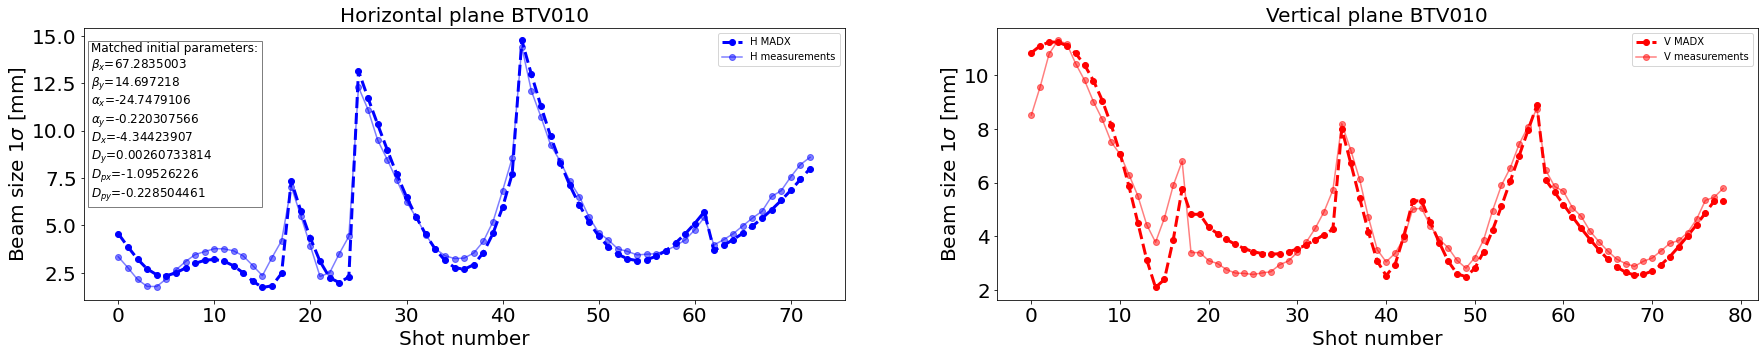

In [15]:
fig, ax = plt.subplots(1,2, figsize=(30,5))

### Horizontal ###

x_axis_total_H = np.linspace(0,len(master_df_H.sigma_H)-1, len(master_df_H.sigma_H))
ax[0].plot(x_axis_total_H, np.array(H_sigma_madx)*1000, color = "b", linestyle = "--", marker = "o", linewidth=3, label = "H MADX")
ax[0].plot(x_axis_total_H, master_df_H.sigma_H, color = "b", alpha=0.5, marker = "o", label = "H measurements")

ax[0].legend()
ax[0].set_xlabel("Shot number", fontsize=20)
ax[0].set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].set_title("Horizontal plane BTV010", fontsize = 20)

### Vertical ###

x_axis_total_V = np.linspace(0,len(master_df_V.sigma_V)-1, len(master_df_V.sigma_V))
ax[1].plot(x_axis_total_V, np.array(V_sigma_madx)*1000, color = "r", linestyle = "--", marker = "o", linewidth=3, label = "V MADX")
ax[1].plot(x_axis_total_V, master_df_V.sigma_V, color = "r",  alpha=0.5, marker = "o", label = "V measurements")

ax[1].legend()
ax[1].set_xlabel("Shot number", fontsize=20)
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].set_title("Vertical plane BTV010", fontsize = 20)

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(betx0),
    r'$\beta_{y}$='+str(bety0),
    r'$\alpha_{x}$='+str(alfx0),
    r'$\alpha_{y}$='+str(alfy0),
    r'$D_{x}$='+str(Dx0),
    r'$D_{y}$='+str(Dy0),
    r'$D_{px}$='+str(Dpx0),
    r'$D_{py}$='+str(Dpy0),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax[0].text(0.01, 0.95, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Comparison between all acquisitions and MADX with matched initial conditions